# **SECTION ONE: PREPARE ENVIRONMENT**

Imports

In [3]:
!pip install shifterator
!pip install pyreadr
!pip install wordcloud
!pip install sklearn
!pip install labMTsimple

import random
import wordcloud
from wordcloud import WordCloud
import plotly.express as px
import pickle
import pandas as pd
import pickle
import os
import numpy as np
import statsmodels.api as sm
import matplotlib
from matplotlib import pyplot as plt
import shifterator as sh
from google.colab import drive
import pyreadr
import json
from collections import Counter
import nltk
import datetime as dt
import sklearn as sk
from sklearn import preprocessing
import scipy
from scipy import stats
import re
import labMTsimple
from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
import datetime
from string import punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')
import datetime as dt
from datetime import time


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.4 MB 87.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 364 kB 26.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=fdbd812b937c44977296048b615f15f1c0c61482b394d623e39730cbf7155241
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.7 MB 18.5 MB/s 
  Created wheel for labMTsimple: filename

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Initiate connection with Google Drive folder

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# **SECTION TWO: CLASSES, METHODS, AND FUNCTIONS**

Define custom PiT object to save annual Point in Time count data

In [5]:
class PiT:

    """ PiT objects store information about each year's Point in Time Count data, which tracks
    annual raw counts of homeless individuals and families.

     Each object stores the year of its data in a string and the data itself as a Pandas DataFrame.
     Each observation contains the reported numbers from a single Continuum of Care, or regional
     homelessness services coordinating entity. These entities do not align with any geographic entitle
     (e.g., county, state), and so special code is required to disaggregate the counts to a county or
     state level."""

    def __init__(self, filepath, yearstr):
        self.data = pd.read_excel(io=os.path.join(os.getcwd(), filepath), sheet_name=yearstr, header=0, index_col=1)
        self.year = yearstr
        self.label = 'PiT Counts ' + yearstr

    def clean_columns(self):
        column_headers = list(self.data.columns)
        new_column_headers = []
        for column in column_headers:
            if column != 'CoC Number':
                new_column_headers.append(column[0:-6:1])
            else:
                new_column_headers.append(column)
        self.data.columns = new_column_headers
        all_column_names = sorted(new_column_headers)
        return (all_column_names)

    def gather_CoCs(self, CoCs, continua):
        for continuum, values in self.data.iterrows():
            if continuum not in continua:
                try:
                    name = values[0][1]
                    CoCs.append(CoC(continuum, name[0:254]))
                    CoCs[-1].CoC_number = values[0]
                    CoCs[-1].state = values[0][0:2]
                    continua.append(continuum)
                except:
                    # print(values[0])
                    pass
        return CoCs, continua

class CoC:

    """CoC organize reported PiT countsand Performance Measures across multiple reporting year
    by each reporting entity, called a Continuum of Care. Also stores administrative information,
    such as the unique CoC number and the state to which the CoC belongs."""

    def __init__(self, name, state):
        self.name = name
        self.state = state
        self.performance = {}
        self.PiT = {}
        self.CoC_number = ''
        self.PiT_schedule = 'unknown'
        self.PiT_start = 'unknown'
        self.PiT_df = pd.DataFrame()

    def CoC_performance(self, perf_list):
        for perf_year in perf_list:
            year = perf_year.year
            try:
                self.performance[year] = perf_year.data.loc[self.name]
                self.CoC_number = self.performance[year]['HUD CoC Number']
            except:
                pass
        return self.performance

    def check_schedule(self):

        """ The check_schedule() function reviews successive years in a CoC's PiT data to determine
        whether the CoC submitted the same information two years in a row, possibly indicating a
        biannual, rather than annual, reporting schedule."""

        counter = 0
        for year1 in self.PiT.keys():
            for year2 in self.PiT.keys():
                if self.PiT[year1] == self.Pit[year2]:
                    counter += 1

class County():
    def __init__(self, countysource, popsource2000, popsource2010):
        self.data = countysource
        self.fips = countysource.fips
        self.statefips = countysource.statefips
        self.countyfips = countysource.countyfips
        self.cname = countysource.cname
        self.cnamecounty = countysource.cnamecounty
        self.state = countysource.state
        self.area = countysource.area
        self.pop10 = countysource.pop10
        self.coc_name = countysource.coc_name
        self.coc_num = countysource.cocnum
        self.imputed = True
        if countysource.imp != 'Imputed':
            self.imputed = False
        self.popdata1 = popsource2000
        self.popdata2 = popsource2010
        self.annualpop = {}

    def annual_pop_replace(self, county, years):
        for year in years:
            if year == '2010':
                heading = 'CENSUS2010POP'
            else:
                heading = 'POPESTIMATE' + str(year)
            if int(year) < 2010:
                self.annualpop[year] = self.popdata1[heading]
            else:
                self.annualpop[year] = self.popdata2[heading]
        print(self.cname, self.annualpop)


Cross-correlation calculation

In [6]:
def cross_correlate(timeseries1, timeseries2):
  cross_correlations = {}

  for state in states_without_dc_or_pr:
    x_ts = list(timeseries1.loc[state])
    y_ts = list(timeseries2.loc[state]) # Indexing only necessary where I forgot to drop('states')
    cross_correlations[state] = sm.tsa.stattools.ccf(x_ts, y_ts, adjusted = False)

  hist_data = {}

  for t in range(len(timeseries1.columns)-1):
    hist_data[t+1] = [(x, cross_correlations[x][t]) for x in cross_correlations.keys()]
  
  return hist_data

Turn dataframe of counts into dataframe of column-wise percentages 

In [7]:
def percentize(df):
  df_copy = df.copy()
  annual_totals_df = pd.DataFrame(columns = df_copy.columns)
  annual_totals_df.loc[len(annual_totals_df)] = [sum(pd.to_numeric(df[col])) for col in df_copy.columns]
  percentage_df = pd.DataFrame(columns = df_copy.columns, index = df_copy.index.values)
  for row in df_copy.index:
    for col in df_copy.columns:
      percentage_df.loc[row][col] = float(df_copy.loc[row][col]/annual_totals_df[col])
  return(percentage_df)

Plotting distribution of cross-correlation scores by year across all states

In [8]:
def boxplot_distr(data, homelesstype):
  fig, ax = plt.subplots()

  boxplot_data = pd.DataFrame.from_dict(data)
  yearlabels = [int(x)+2010 for x in data.keys()]

  ax.boxplot(boxplot_data[1:10])
  plt.title('Distribution of cross-correlation measures\nbetween ' + homelesstype + ' homelessness and tweet volume')
  ax.set_xticks(range(len(data.keys())), yearlabels)
  ax.set_xlabel('Year')
  ax.set_ylabel('Cross-correlation')
  plt.show()


Plotting choropleth map

In [9]:
def choro_map(counts_by_state, year, var):
    counts_by_state[year] = pd.to_numeric(counts_by_state[year])

    title_text = year + ' per capita counts by state of ' + var
    
    fig = px.choropleth(data_frame=counts_by_state,
                        locations= counts_by_state.index.values, 
                        locationmode="USA-states", 
                        scope="usa",
                        color=year,
                        color_continuous_scale = px.colors.sequential.amp,
                        )
    
    fig.update_layout(
          title_text = title_text,
          title_font_family="Times New Roman",
          title_font_size = 22,
          title_font_color="black",
          title_x=0.45,
    )
    fig.show()

Plotting word shift diagram between two different corpuses

In [10]:
def word_shift(corp1, corp2, alpha, desc1, desc2):
  entropy_shift = sh.EntropyShift(type2freq_1=corp1,
                                type2freq_2=corp2,
                                base=2,reference_value = 'average',
                                alpha=alpha)
  entropy_shift.get_shift_graph(system_names = [desc1, desc2])


Extract words from tweet for word shift diagrams

In [11]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def words_of_tweet(tweet):
  tweet_copy = remove_emojis(tweet)
  exclude = set(punctuation)  # Keep a set of "bad" characters.
  list_letters_noPunct = [char for char in tweet_copy if char not in exclude]
  text_noPunct = "".join(list_letters_noPunct)
  list_words = text_noPunct.strip().split()
  list_words = [word.lower() for word in list_words]
  return list_words

Animates choropleth maps for multiple years of data

In [12]:
def choro_map_animated(df):
  for year in df.columns:
    try:
      df[year] = pd.to_numeric(df[year])
    except:
      print(year)
    
  title_text = "US state-level homelessness rates"

  fig = px.choropleth(data_frame= df,
                      locations= "state", 
                      locationmode="USA-states", 
                      scope="usa",
                      color="rate",
                      color_continuous_scale = px.colors.sequential.amp,
                      title = title_text,
                      animation_frame="year", height=600
                      )

  fig.update_layout(
      title_text = title_text,
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black",
      title_x=0.45,
    )

  fig.show()

Convert DataFrame of counts indexed by state into DataFrame where each column ranks states 

In [13]:
def rankify(df):
  df_copy = df.copy()
  df_copy = df_copy.reset_index(drop = True)
  ranks_df = pd.DataFrame(columns = df_copy.columns)
  df_copy['state'] = states_without_dc_or_pr
  for col in ranks_df.columns:
    thisyear = df_copy.sort_values(by=col, ascending = False)
    thisyear.reset_index(drop = True, inplace = True)
    ranks_df[col] = thisyear['state']
    df_copy.reset_index(drop = True, inplace = True)
    ranks_df.reset_index(drop = True, inplace = True)
  return ranks_df

Convert mxn Dataframe of annualized counts into mx(n-1) DataFrame of annualized changes in those counts from year x-1 to year x 

In [14]:
def percapita_changes(df):
  change_range = df.columns[1::]
  percapita_delta = pd.DataFrame(columns = change_range)
  for state in df.index:
    for year in change_range:
        percapita_delta.at[state, year] = df.loc[state][year] - df.loc[state][str(int(year)-1)]
  return percapita_delta

Returns dataframe of Spearman rank correlation coefficients

In [15]:
def Spearman_stats(df1, df2, column_names, columns):
  stat_sig = []
  correlation_df = pd.DataFrame(columns = column_names, index = ['Spearman coef', 'Spearman p-value'])
  if columns == True:
    for year in correlation_df.columns:
      spearman_stats = scipy.stats.spearmanr(df1[year], df2[year])
      correlation_df.at['Spearman coef', year] = spearman_stats[0]
      correlation_df.at['Spearman p-value', year] = spearman_stats[1]
      if spearman_stats[1] < 0.05:
        stat_sig.append(year)
  else:
    for state in correlation_df.index.columns:
      spearman_stats = scipy.stats.spearmanr[df1.loc[state], df2.loc[state]]
      correlation_df.at['Spearman coef', state] = spearman_stats[0]
      correlation_df.at['Spearman p-value', state] = spearman_stats[1]  
      if spearman_stats[1] < 0.05:
        stat_sig.append(state)
  return correlation_df, stat_sig
      

Returns dataframe of Pearson correlation coefficients

In [16]:
def Pearson_stats(df1, df2, row_names, columns):
  correlation_df = pd.DataFrame(columns = ['Pearson coef', 'Pearson p-value'], index = row_names)
  stat_sig = []

  if columns == True:
    for year in correlation_df.columns:
      pearson_stats = scipy.stats.pearsonr(df1[year], df2[year])
      correlation_df.at['Pearson coef', year] = pearson_stats[0]
      correlation_df.at['Pearson p-value', year] = pearson_stats[1]
      if pearson_stats[1] < 0.05:
        stat_sig.append(year)
  else:
    for state in row_names:
      pearson_stats = scipy.stats.pearsonr(df1.loc[state], df2.loc[state])
      correlation_df.at[state, 'Pearson coef'] = pearson_stats[0]
      correlation_df.at[state, 'Pearson p-value'] = pearson_stats[1]
      if pearson_stats[1] < 0.05:
        stat_sig.append(state)
  return correlation_df, stat_sig

Prepares two DataFrames of tweets for allotaxonometry analysis using Matlab code

In [17]:
def prep_allotax(df1, df2):
  lefthanddata = []
  righthanddata = []
  lefthandcorpus = []
  righthandcorpus = []
  stops = set(stopwords.words('english'))

  for index, row in df1.iterrows():
    try:
      lefthanddata.append(words_of_tweet(row['text']))
      righthanddata.append(words_of_tweet(df2.loc[index]['text']))
    except:
      pass

  for tweet in lefthanddata:
    for word in tweet:
      if "http" not in word and word not in stops:
        lefthandcorpus.append(word)

  for tweet in righthanddata:
    for word in tweet:
      if "http" not in word and word not in stops:
        righthandcorpus.append(word)
    
  lefthandcounter = Counter(lefthandcorpus)
  righthandcounter = Counter(righthandcorpus)

  LH_df = pd.DataFrame.from_dict(dict(lefthandcounter), orient = 'index')
  RH_df = pd.DataFrame.from_dict(dict(righthandcounter), orient = 'index')

  LH_df.rename(columns = {0: 'counts'}, inplace = True)
  RH_df.rename(columns = {0: 'counts'}, inplace = True)

  # LH_df['rank'] = LH_df['counts'].rank(method = 'average', ascending = False)
  # RH_df['rank'] = RH_df['counts'].rank(method = 'average', ascending = False)

  # LH_df.drop('counts', axis = 'columns', inplace = True)
  # RH_df.drop('counts', axis = 'columns', inplace = True)

  # return(lefthandcounter, righthandcounter)

  return(LH_df, RH_df)

# **SECTION THREE: LOAD/INSTANTIATE USEFUL OBJECTS**


Cheat sheet of objects to speed up conversion between states and postal codes

In [18]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46', 'Puerto Rico': '72'
}

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'Puerto Rico']

us_state_to_abbrev = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
          "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
          "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL",
          "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
          "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI",
          "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
          "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
          "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
          "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
          "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
          "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
          "Wisconsin": "WI", "Wyoming": "WY",
          "Puerto Rico": "PR",
          "District of Columbia": "DC",
          # "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP",
          # "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"
}

us_abbrev_to_state = dict(map(reversed, us_state_to_abbrev.items()))
us_abbrev_to_state['Puerto Rico'] = 'Puerto Rico'
statenames = sorted(us_state_to_abbrev.keys())
states_without_dc_or_pr = [state for state in states if state != 'DC' and state != 'Puerto Rico']
states_without_pr = [state for state in states if state != 'Puerto Rico']

One Year Population Estimates 2010-2019 data

In [19]:
state_annual_est = pd.read_excel('drive/MyDrive/POCS FP/population/nst-est2019-01.xlsx', usecols='A, B,D:M', engine='openpyxl', skiprows=[0, 1, 2, 4, 5, 6, 7, 8, 60, 62, 63, 64, 65, 66])

for index, state in enumerate(state_annual_est['Unnamed: 0']):
    if '.' == state_annual_est.loc[index]['Unnamed: 0'][0]:
        state_annual_est.at[index, 'Unnamed: 0'] = us_state_to_abbrev[state_annual_est.loc[index]['Unnamed: 0'][1::]]
    else:
        state_annual_est.at[index, 'Unnamed: 0'] = us_state_to_abbrev[state_annual_est.loc[index]['Unnamed: 0']]

state_annual_est.set_index(keys = 'Unnamed: 0', inplace = True, drop = True)

National population estimates by year

In [20]:
nation_annual_est_pop = pd.DataFrame(columns = state_annual_est.columns)
nation_annual_est_pop.loc[len(nation_annual_est_pop)] = [sum(state_annual_est[col]) for col in state_annual_est.columns]

Loads every object necessary to run analysis and visualizations below

In [ ]:
# DataFrame of raw counts of total homeless by state-year
raw_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/raw_totalhomeless.csv', engine = 'c', encoding = 'latin1')
raw_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of per capita counts of total homeless by state-year
normalized_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/normalized_total.csv', engine='c', encoding='latin1')
normalized_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of per capita counts of unsheltered homeless by state-year
normalized_unshelteredhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/normalized_unsheltered.csv', engine='c', encoding='latin1')
normalized_unshelteredhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of log-transformed per capita counts of unsheltered homeless by state-year
lognormal_unshelteredhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/lognormal_unsheltered.csv', engine = 'c', encoding='latin1')
lognormal_unshelteredhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of log-transformed per capita counts of total homeless by state-year
lognormal_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/lognormal_total.csv', engine = 'c', encoding = 'latin1')
lognormal_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of total homeless density (persons per square land mile) by state-year
persqmi_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/persqmi_homeless.csv', engine = 'c', encoding = 'latin1')
persqmi_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of all 3/1/2010 - 12/31/2019 tweets including state-year column
df_w_stateyears = pd.read_csv('drive/MyDrive/POCS FP/tweets/all_geotagged_tweets_w_stateyears.csv', engine='c', encoding='utf-8', usecols = ['id', 'text', 'created_at', 'author_id', 'author', 'geo', 'year', 'bbox', 'exact_coordinates', 'state', 'place_type', 'full_name', 'stateyear'])

# DataFrame of per capita changes in total homelessness between consecutive years by state-year
percapita_changes_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/percapita_changes_totalhomeless.csv')

# DataFrame of raw tweet counts by state-year
raw_counts_by_state = pd.read_csv('drive/MyDrive/POCS FP/tweet_counts/raw_counts_by_state.csv', engine = 'c', encoding = 'latin-1')
raw_counts_by_state.set_index(keys = 'Unnamed: 0', drop = True, inplace = True)

# DataFrame of per capita tweet counts by state-year
percapita_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweets/percapita_tweets', engine = 'c', encoding = 'latin-1')
percapita_tweets.set_index(keys = 'Unnamed: 0', drop = True, inplace = True)

# DataFrame of proportion of state-year tweets to total nation-year tweets 
percents_of_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweets/percents_of_total_twitter_activity.csv', engine='c', encoding='latin1')
percents_of_tweets.set_index("Unnamed: 0", drop = True, inplace = True)

# DataFrame of per capita changes in raw tweet counts between consecutive years by state-year
changes_percapita_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweet_counts/changes_percapita', engine = 'c', encoding = 'latin-1')
changes_percapita_tweets.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame from dictionary of counts for tokens in tweets during years of 
# nationwide decreasing vs. increasing homelessness - count1 = 2010-2015, 
# count2 = 2016-2019  
allyears = pd.read_csv('drive/MyDrive/POCS FP/tweet_content/allyears.csv', engine = 'c', encoding = 'latin-1')
allyears.set_index('Unnamed: 0', drop = True, inplace = True)
allyears.drop(0, axis = 'rows')

Generates DataFrames of token counts for 2010-2015 and for 2016-2020

In [22]:
# pre2017 = allyears[allyears['count1'] != 0][['token', 'count1']]
# post2017 = allyears[allyears['count2'] != 0][['token', 'count2']]

# pre2017.rename(columns = {'count1': 'count'}, inplace = True)
# pre2017.set_index('token', drop = True, inplace = True)
# post2017.rename(columns = {'count2': 'count'}, inplace = True)
# post2017.set_index('token', drop = True, inplace = True)

# pre2017.to_csv('drive/MyDrive/POCS FP/tweet_content/pre2017.tsv', sep = '\t')
# post2017.to_csv('drive/MyDrive/POCS FP/tweet_content/post2017.tsv', sep = '\t')

Assigns rank column to DataFrame of decreasing-increasing homelessness counts

In [23]:
# pre2017['rank'] = pre2017['count'].rank(method = 'average', ascending = False)
# post2017['rank'] = post2017['count'].rank(method = 'average', ascending = False)

# **SECTION THREE, ALTERNATE: RE-DERIVE USEFUL OBJECTS**

Re-derive clean homelessness datasets

In [ ]:
# DO NOT RUN THIS CELL - USE THE NEXT CELL TO LOAD THE .CSV FILES

# LOADS EACH YEAR'S WORKSHEET FROM PiT DATASET INTO SEPARATE CUSTOM PiT OBJECT WITH CLEAN COLUMN HEADINGS

# column_headings_for_each_PiT_table = []
# PiT_tables = []

# for i in range(2007, 2021):
#     PiT_tables.append(PiT('drive/MyDrive/POCS FP/homelessness/2007-2021-PIT-Counts-by-CoC.xlsx', str(i)))
#     column_headings_for_each_PiT_table.append(PiT_tables[-1].clean_columns())

# normalized_totalhomeless = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)
# normalized_unshelteredhomeless = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)
# raw_totalhomeless = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)
# raw_unshelteredhomeless = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)

# lognormal_totalhomeless = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)
# lognormal_unshelteredhomeless = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)


# for table in PiT_tables:
#     state_list = []
#     for coc_number in table.data['CoC Number']:
#         try:
#             state_list.append(coc_number[0:2])
#             PiT_tables[0].data['State'] = coc_number[0:2]
#         except:
#             state_list.append(np.NaN)
#     table.data['State'] = state_list

# for year in range(2010, 2020):
#     for table in PiT_tables:
#         if table.year == str(year):
#             key_table = table.data
#     for state in states_without_dc_or_pr:
#         try:
#             state_unsheltered_sum = sum(key_table.loc[key_table['State'] == state]['Unsheltered Homeless'])
#             state_total_sum = sum(key_table.loc[key_table['State'] == state]['Overall Homeless'])
#             raw_unshelteredhomeless.at[state, str(year)] = state_unsheltered_sum
#             raw_totalhomeless.at[state, str(year)] = state_total_sum
#             normalization_factor = state_annual_est.loc[state][year]
#             normalized_unshelteredhomeless.at[state, str(year)] = state_unsheltered_sum/normalization_factor
#             normalized_totalhomeless.at[state, str(year)] = state_total_sum/normalization_factor
#             lognormal_unshelteredhomeless.at[state, str(year)] = np.log(state_unsheltered_sum/normalization_factor)
#             lognormal_totalhomeless.at[state, str(year)] = np.log(state_total_sum/normalization_factor)
#         except:
#             print(year, state)

# raw_totalhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/raw_totalhomeless.csv')
# normalized_unshelteredhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/normalized_unsheltered.csv')
# normalized_totalhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/normalized_total.csv')
# lognormal_unshelteredhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/lognormal_unsheltered.csv')
# lognormal_totalhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/lognormal_total.csv')


In [ ]:
# state_areas = pd.read_csv('drive/MyDrive/POCS FP/population/state_areas.csv')
# state_areas['State'].replace(us_state_to_abbrev, inplace = True)
# state_areas.set_index('State', drop = True, inplace = True)
# state_areas

In [ ]:
# persqmi_totalhomeless = pd.DataFrame(index = raw_totalhomeless.index, columns = raw_totalhomeless.columns)
# for col in persqmi_totalhomeless:
#   persqmi_totalhomeless[col] = raw_totalhomeless[col]/state_areas['Land_sq_miles']

# persqmi_totalhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/persqmi_homeless.csv')

Load geotagged tweets into single dataframe, loads dictionary of geoid data, adds "state" and "year" columns

In [ ]:
## DO NOT RUN THIS CODE - ONLY HERE TO RECONSTRUCT IF .CSV FILES ARE LOST SEE NEXT TWO CELLS!

# errorcounter = 0
# missing_states = []
# sfcounter = 0
# state_counter = 0

# # geotagged_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweets/geotagged_010107_123118', engine='c', encoding='latin1')
# geotagged_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweets/geotagged_010119_123119', engine='c', encoding='latin1')
# geotagged_tweets['year'] = ''
# geotagged_tweets['bbox'] = np.NaN
# geotagged_tweets['exact_coordinates'] = np.NaN
# geotagged_tweets['bbox'].loc[geotagged_tweets['bbox'].isnull()] = geotagged_tweets['bbox'].loc[
#     geotagged_tweets['bbox'].isnull()].apply(lambda x: [])
# geotagged_tweets['exact_coordinates'].loc[geotagged_tweets['exact_coordinates'].isnull()] = \
#     geotagged_tweets['exact_coordinates'].loc[geotagged_tweets['exact_coordinates'].isnull()].apply(lambda x: [])
# geotagged_tweets['state'] = 'Unknown'

# for index, geodict in enumerate(geotagged_tweets['geo']):
#     try:
#         thisdict = json.loads(geodict)
#         geotagged_tweets.at[index, 'geo'] = thisdict
#         geotagged_tweets.at[index, 'place_type'] = thisdict['place_type']
#         geotagged_tweets.at[index, 'full_name'] = thisdict['full_name']
#         state_bool = False
#         if 'San Francisco' in str(thisdict['full_name']) or 'San Fran' in str(thisdict['full_name']) or 'SF' in str(thisdict['full_name']):
#             state_name = 'CA'
#             sfcounter +=1
#         else:
#           if ',' in str(thisdict['full_name']):
#               state_name = str(thisdict['full_name']).split(',')[1].strip()
#               if state_name == 'USA':
#                   state_name = str(thisdict['full_name']).split(',')[0].strip()
#           else:
#               state_name = str(thisdict['full_name']).strip('.').upper().split(' ')[-1]
#         if state_name in states:
#             state_bool = True
#             geotagged_tweets.at[index, 'state'] = state_name
#         else:
#             if state_name in us_state_to_abbrev.keys():
#                 geotagged_tweets.at[index, 'state'] = us_state_to_abbrev[state_name]
#             else:
#                 missing_states.append(thisdict['full_name'])
#         if 'bbox' in thisdict['geo'].keys():
#             for coordinate in thisdict['geo']['bbox']:
#                 geotagged_tweets.loc[index]['bbox'].append(coordinate)
#         if 'coordinates' in thisdict['geo'].keys():
#             for coordinate in thisdict['geo']['coordinates']:
#                 geotagged_tweets.loc[index]['exact_coordinates'].append(coordinate)
#         year = str(geotagged_tweets.loc[index]['created_at'])[0:4]
#         geotagged_tweets.at[index, 'year'] = year
#     except:
#         errorcounter += 1

# # df1 = geotagged_tweets
# df2 = geotagged_tweets

# # df1.to_csv('drive/MyDrive/POCS FP/tweets_010107_123118.csv')
# df2.to_csv('drive/MyDrive/POCS FP/tweets_010119_123119.csv')

In [ ]:
# df = pd.concat([df1, df2], ignore_index = True)
# df.to_csv('drive/MyDrive/POCS FP/tweets/all_geotagged_tweets.csv')

In [ ]:
## DO NOT USE - THIS CELL WILL LOAD ALL TWEETS FROM 1/1/07 - 12/31/19
## SKIP AHEAD TO CELL THAT LOADS TWEETS WITH STATEYEAR INFORMATION INTEGRATED INTO DATAFRAME

# df = pd.read_csv('drive/MyDrive/POCS FP/tweets/all_geotagged_tweets.csv', engine='c', encoding='latin1', usecols = ['id', 'text', 'created_at', 'author_id', 'author', 'geo', 'year', 'bbox', 'exact_coordinates', 'state', 'place_type', 'full_name'])



In [ ]:
## DO NOT RUN - USE NEXT CELL

# df['stateyear'] = np.NaN
# df['stateyear'].loc[df['stateyear'].isnull()] = df['stateyear'].loc[
#     df['stateyear'].isnull()].apply(lambda x: tuple())

# for ind in df.index:
#   try:
#     if df.loc[ind]['state'] in states_without_dc_or_pr:
#       thisstate = df.loc[ind]['state']
#       thisyear = str(int(df.loc[ind]['year']))
#       df.at[ind, 'stateyear'] = df.loc[ind, 'stateyear'] + tuple([thisstate])
#       df.at[ind, 'stateyear'] = df.loc[ind, 'stateyear'] + tuple([thisyear])
#     else:
#       df.at[ind, 'stateyear'] = df.loc[ind, 'stateyear'] + tuple(['Invalid state'])
#   except:
#     df.at[ind, 'stateyear'] = df.loc[ind, 'stateyear'] + tuple(['Unknown stateyear'])

# df.to_csv('drive/MyDrive/POCS FP/tweets/all_geotagged_tweets_w_stateyears.csv')

Create DataFrame of change per capita from year x to year x + 1, print list of states by year with highest increase

In [ ]:
# percapita_changes_totalhomeless = pd.DataFrame(columns = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)
# percapita_changes_unshelteredhomeless = pd.DataFrame(columns = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)

# for state in normalized_totalhomeless.index:
#   for year in normalized_totalhomeless.columns:
#     if year != '2010':
#       percapita_changes_totalhomeless.at[state, year] = normalized_totalhomeless.loc[state][year] - normalized_totalhomeless.loc[state][str(int(year)-1)]

# for year in percapita_changes_totalhomeless.columns:
#   for state in percapita_changes_totalhomeless.index:
#     if percapita_changes_totalhomeless.loc[state][year] == max(percapita_changes_totalhomeless[year]):
#       print(year, state)

# for state in normalized_unshelteredhomeless.index.values:
#   for year in normalized_unshelteredhomeless.columns:
#     if year != '2010':
#       percapita_changes_unshelteredhomeless.at[state, year] = normalized_unshelteredhomeless.loc[state][year] - normalized_unshelteredhomeless.loc[state][str(int(year)-1)]


In [ ]:
# percapita_changes_totalhomeless.to_csv('drive/MyDrive/POCS FP/homelessness/percapita_changes_totalhomeless.csv')

Convert DataFrame of per capita changes to ranked state abbreviations reflecting changes in per capita homelessness count

In [1]:
# percapita_changes_total_ranked = rankify(percapita_changes_totalhomeless)
# percapita_changes_unshelt_ranked = rankify(percapita_changes_unshelteredhomeless)

Create DataFrame of changes in per capita tweet rates, then converts it to DataFrame of ranked changes by year

In [ ]:
# percapita_changes_tweets_ranked = rankify(percapita_changes(raw_counts_by_state))
# percapita_tweets_ranked = rankify(percapita_tweets)
# raw_tweets_ranked = rankify(raw_counts_by_state)

In [ ]:
# percapita_tweets_ranked

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,NH,HI,RI,MA,OR,NV,CA,CA,NV,NV
1,SC,MD,NV,HI,WI,CA,NV,NV,CA,CA
2,MT,VT,MD,RI,MA,WA,WA,HI,HI,WA
3,OR,GA,MA,NV,HI,HI,OR,OR,WA,OR
4,ND,IL,HI,CA,CA,MD,HI,WA,OR,HI
5,NV,CA,CA,NY,NV,WI,NY,NY,NY,NY
6,MD,NV,GA,WA,VT,OR,MA,MD,MD,KS
7,AK,OR,NJ,ND,NY,CO,CO,LA,MA,MD
8,ME,AK,CT,IL,WA,MA,TX,UT,CT,GA
9,CA,SC,IL,OH,MD,NY,LA,MA,FL,TX


Creates DataFrame of changes in per capita tweets between successive years 

In [ ]:
# changes_percapita_tweets.to_csv('drive/MyDrive/POCS FP/tweet_counts/changes_percapita')

Create DataFrame of ranked states according to their respective proportions of the total tweet counts for each year

In [ ]:
# rank_tweet_percentages = rankify(rank_tweet_percentages)
# rank_tweet_percentages

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA
1,FL,NY,NY,TX,TX,TX,TX,TX,TX,TX
2,TX,IL,TX,NY,NY,NY,NY,NY,NY,NY
3,PA,TX,FL,FL,FL,FL,FL,FL,FL,FL
4,GA,FL,IL,IL,PA,IL,IL,IL,WA,GA
5,NJ,GA,OH,PA,IL,PA,WA,GA,PA,WA
6,IL,PA,PA,OH,OH,WA,OH,PA,GA,IL
7,NY,MD,GA,MA,WI,OH,GA,WA,IL,PA
8,MD,OH,NJ,MI,GA,GA,PA,OH,OH,OH
9,SC,NJ,MA,GA,MA,MA,VA,VA,NC,NC


Creates rank DataFrame for percentages of geotagged US tweets

In [ ]:
# rank_tweet_percentages = pd.DataFrame(columns = percents_of_tweets.columns, index = percents_of_tweets.index.values)
# for col in percents_of_tweets.columns:
#   rank_tweet_percentages[col] = percents_of_tweets[col].rank(method = 'average')
# rank_tweet_percentages

# **SECTION FOUR: VISUALIZATIONS AND EXPLORATORY DATA ANALYSIS**

# *Homelessness Rates EDA*

#Calculate average raw total homelessness count nationwide across all years

In [24]:
cumsum = 0
for year in raw_totalhomeless.columns:
  cumsum += sum(raw_totalhomeless[year])
print("On average, there were " + str(cumsum/len(raw_totalhomeless.columns)) +' homeless people in America in any given year between 2007 and 2019.')


On average, there were 570744.3 homeless people in America in any given year between 2007 and 2019.


# Add row containing variance by year to end of raw count DataFrame

In [25]:
raw_totalhomeless.drop(raw_totalhomeless.tail(1).index,inplace=True)
raw_totalhomeless.loc[len(raw_totalhomeless)] = [np.var(raw_totalhomeless[col]) for col in raw_totalhomeless.columns]

In [ ]:
raw_totalhomeless

In [33]:
raw_totalhomeless.drop(49, inplace = True)

# Add row containing variance by year to end of per capita count DataFrame and column containing variance by state

In [27]:
normalized_totalhomeless.loc[len(normalized_totalhomeless)] = [np.var(normalized_totalhomeless[col]) for col in normalized_totalhomeless.columns]

In [29]:

for state in normalized_totalhomeless.index.values:
  normalized_totalhomeless.at[state, 'State Variance'] = np.var(normalized_totalhomeless.loc[state])

In [30]:
normalized_totalhomeless.drop(50, inplace = True)
normalized_totalhomeless

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,State Variance
Unnamed: 0,,,,,,,,,,,
AK,0.002610,0.002947,0.002619,0.002640,0.002423,0.002652,0.002616,0.002494,0.002742,0.002607,1.758955e-08
AL,0.001263,0.001158,0.001082,0.000971,0.000942,0.000818,0.000845,0.000778,0.000703,0.000665,3.521290e-08
AR,0.000945,0.001164,0.001427,0.001288,0.000989,0.000860,0.000824,0.000822,0.000901,0.000900,3.965280e-08
AZ,0.002140,0.001623,0.001724,0.001592,0.001559,0.001449,0.001398,0.001270,0.001378,0.001375,5.572406e-08
CA,0.003309,0.003324,0.003165,0.003099,0.002952,0.002974,0.003016,0.003342,0.003294,0.003829,5.999272e-08
CO,0.003067,0.002952,0.003229,0.001851,0.001874,0.001826,0.001905,0.001949,0.001908,0.001670,3.254823e-07
CT,0.001206,0.001242,0.001171,0.001237,0.001238,0.001128,0.001091,0.000948,0.001113,0.000851,1.554763e-08
DE,0.001092,0.001141,0.001101,0.001024,0.000966,0.001012,0.001128,0.001039,0.001121,0.000946,4.319008e-09
FL,0.003054,0.002975,0.002859,0.002449,0.002093,0.001776,0.001628,0.001536,0.001461,0.001319,4.036009e-07


In [31]:
normalized_totalhomeless.drop(['State Variance'], axis = 'columns')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Unnamed: 0,,,,,,,,,,
AK,0.002610,0.002947,0.002619,0.002640,0.002423,0.002652,0.002616,0.002494,0.002742,0.002607
AL,0.001263,0.001158,0.001082,0.000971,0.000942,0.000818,0.000845,0.000778,0.000703,0.000665
AR,0.000945,0.001164,0.001427,0.001288,0.000989,0.000860,0.000824,0.000822,0.000901,0.000900
AZ,0.002140,0.001623,0.001724,0.001592,0.001559,0.001449,0.001398,0.001270,0.001378,0.001375
CA,0.003309,0.003324,0.003165,0.003099,0.002952,0.002974,0.003016,0.003342,0.003294,0.003829
CO,0.003067,0.002952,0.003229,0.001851,0.001874,0.001826,0.001905,0.001949,0.001908,0.001670
CT,0.001206,0.001242,0.001171,0.001237,0.001238,0.001128,0.001091,0.000948,0.001113,0.000851
DE,0.001092,0.001141,0.001101,0.001024,0.000966,0.001012,0.001128,0.001039,0.001121,0.000946
FL,0.003054,0.002975,0.002859,0.002449,0.002093,0.001776,0.001628,0.001536,0.001461,0.001319


# Creates a list of maximum values of per capita homelessness rates and per sq mile homelessness densities for each state, then prints the list in descending order 

In [34]:
rank_max_percapita = {}
rank_max_persqmi = {}
for state in states_without_dc_or_pr: 
  rank_max_percapita[state] = np.max(normalized_totalhomeless.loc[state])
  rank_max_persqmi[state] = np.max(persqmi_totalhomeless.loc[state])

counter = 50
for val in sorted(list(rank_max_persqmi.values())):
    for key, val2 in rank_max_persqmi.items():
      if val == val2:
        print(counter, key, val)
        counter -=1

50 AK 0.0037291396867732
49 MT 0.0129031371525153
48 SD 0.0152880188890794
47 WY 0.0186728188437889
46 ID 0.0283871592270367
45 NM 0.0296872166070339
44 ND 0.029985072680106
43 KS 0.0308345258625961
42 UT 0.0429232079834489
41 NE 0.0504660002082682
40 IA 0.0561075603773922
39 MS 0.058457472881103
38 OK 0.0762300459217144
37 AR 0.0809839531084846
36 ME 0.097785559122005
35 WV 0.100257924952159
34 NV 0.1020668421675882
33 MN 0.1052030090296005
32 WI 0.1169356327781675
31 AL 0.1193799980254714
30 AZ 0.1207017976301565
29 TX 0.1412958596190359
28 MO 0.1522068022460795
27 CO 0.1617876922483163
26 KY 0.1677303348022083
25 VT 0.1691439730931973
24 NH 0.1758069920696973
23 IN 0.1800926701278401
22 OR 0.2030670500479226
21 SC 0.2176906955856425
20 VA 0.229931628260319
19 MI 0.2332018606625515
18 TN 0.2492057717958045
17 IL 0.2592806066391686
16 NC 0.2781685795384425
15 LA 0.2889084344042218
14 OH 0.3420621130173025
13 WA 0.3442578548212351
12 PA 0.3446572648235478
11 GA 0.3647001547476223
10 DE

# Generate table of summary statistics for each year of homelessness density data

In [35]:
means = []
std = []
mins = []
max = []
twentyfives = []
medians = []
seventyfives = []
IQRs = []

for col in persqmi_totalhomeless.columns:
  means.append(persqmi_totalhomeless[col].describe().loc['mean'])
  std.append(persqmi_totalhomeless[col].describe().loc['std'])
  mins.append(persqmi_totalhomeless[col].describe().loc['min'])
  max.append(persqmi_totalhomeless[col].describe().loc['max'])
  twentyfives.append((persqmi_totalhomeless[col].describe().loc['25%']))
  medians.append(persqmi_totalhomeless[col].describe().loc['50%'])
  seventyfives.append(persqmi_totalhomeless[col].describe().loc['75%'])
  IQRs.append(seventyfives[-1]-twentyfives[-1])

persqmisummarystats = pd.DataFrame(columns = ['Mean', 'Standard Deviation', 'Variance', 'Minimum', 'Maximum', '25%', 'Median', '75%', 'IQR'], index = normalized_totalhomeless.columns)

for index, val in enumerate(means):
  persqmisummarystats.loc[str(2010 + index)] = [means[index], std[index], std[index]**2, mins[index], max[index], twentyfives[index], medians[index], seventyfives[index], IQRs[index]]

print(np.mean(persqmisummarystats['Variance']))

print('\n')

print('\n\nSummary statistics of US State-Level Per Square Mile Homelessness Rates\n')
persqmisummarystats



0.24811783516205774




Summary statistics of US State-Level Per Square Mile Homelessness Rates



,Mean,Standard Deviation,Variance,Minimum,Maximum,25%,Median,75%,IQR
2010,0.346919,0.48548,0.235691,0.003265,2.134103,0.062901,0.149089,0.320224,0.257323
2011,0.340009,0.481578,0.231918,0.003729,2.13641,0.066208,0.149331,0.316054,0.249846
2012,0.341974,0.488005,0.238149,0.003352,2.243718,0.074368,0.156997,0.324144,0.249776
2013,0.336625,0.50514,0.255166,0.00341,2.439615,0.064154,0.131464,0.288122,0.223968
2014,0.333018,0.52512,0.275751,0.003126,2.722692,0.057592,0.119263,0.284819,0.227227
2015,0.326381,0.52411,0.274691,0.003428,2.709615,0.055086,0.113383,0.265188,0.210101
2016,0.313898,0.50038,0.25038,0.0034,2.513846,0.055566,0.106137,0.247078,0.191512
2017,0.300765,0.47616,0.226728,0.003233,2.251923,0.050619,0.103745,0.235669,0.18505
2018,0.30845,0.508582,0.258656,0.003533,2.572821,0.051812,0.100821,0.236045,0.184232
2019,0.296119,0.483786,0.234049,0.003342,2.368077,0.053535,0.101741,0.237775,0.18424


# Get DataFrame of rankings for per capita homelessness by state-year

In [36]:
ranked_total_homeless_per_capita_dict = {}
ranked_total_homeless_per_capita = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])

## GET TOP TEN LISTS OF NORMALIZED TOTAL HOMELESSNESS RATES BY STATE

for year in range(2010, 2020):
  thisyear = normalized_totalhomeless[str(int(year))]
  rankings = thisyear.sort_values(ascending = False)
  thiscolumn = rankings.index.values
  ranked_total_homeless_per_capita_dict[str(year)]  = thiscolumn
  ranked_total_homeless_per_capita = pd.DataFrame.from_dict(ranked_total_homeless_per_capita_dict, orient = "columns")

print(ranked_total_homeless_per_capita)


   2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
0    OR   HI   HI   HI   HI   HI   HI   HI   NY   NY
1    HI   OR   OR   NY   NY   NY   NY   NY   HI   HI
2    NV   NV   NY   OR   MA   OR   OR   OR   OR   CA
3    WA   CA   CO   CA   OR   MA   CA   CA   CA   OR
4    NY   NY   CA   ND   NV   NV   MA   WA   WA   WA
5    CA   WA   WY   MA   CA   CA   WA   NV   MA   MA
6    CO   FL   NV   AK   WA   WA   AK   MA   AK   AK
7    FL   CO   WA   WA   VT   AK   NV   AK   NV   NV
8    LA   AK   FL   NV   AK   VT   CO   VT   VT   VT
9    AK   MA   MA   FL   FL   CO   VT   CO   CO   CO
10   MA   GA   AK   VT   ME   ME   ME   ME   ME   ME
11   AZ   LA   GA   ME   CO   FL   FL   FL   FL   NM
12   NE   NE   NE   MT   MT   ND   WY   WY   AZ   MN
13   GA   ME   VT   CO   ND   MT   NE   MT   MT   AZ
14   VT   WY   MT   GA   GA   NE   AZ   ND   SD   FL
15   MD   VT   ME   NE   NE   AZ   MT   MN   MN   ID
16   ME   MT   MO   WY   AZ   MD   ID   NE   NE   MT
17   NM   MD   AZ   AZ   MN   TN   MN   AZ   N

In [ ]:
ranked_total_homeless_persqmi_dict = {}
ranked_total_homeless_persqmi = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])

for year in range(2010, 2020):
  thisyear = persqmi_totalhomeless[str(int(year))]
  rankings = thisyear.sort_values(ascending = False)
  thiscolumn = rankings.index.values
  ranked_total_homeless_persqmi_dict[str(year)]  = thiscolumn
  ranked_total_homeless_persqmi = pd.DataFrame.from_dict(ranked_total_homeless_persqmi_dict, orient = "columns")

print(ranked_total_homeless_persqmi)

   2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
0    MA   MA   MA   MA   MA   MA   MA   MA   MA   MA
1    NJ   NJ   NJ   NY   NY   NY   NY   NY   NY   NY
2    NY   NY   NY   NJ   NJ   NJ   HI   NJ   NJ   NJ
3    RI   FL   RI   RI   RI   HI   NJ   RI   RI   RI
4    MD   MD   FL   HI   HI   RI   RI   HI   HI   HI
5    FL   RI   MD   CT   CT   MD   CT   CA   CA   CA
6    HI   HI   HI   FL   MD   CT   MD   MD   CT   MD
7    CT   CT   CT   MD   FL   CA   CA   CT   MD   CT
8    CA   CA   CA   CA   CA   FL   FL   FL   FL   FL
9    DE   DE   DE   DE   DE   DE   DE   DE   DE   DE
10   GA   GA   GA   PA   PA   PA   PA   WA   WA   WA
11   WA   PA   OH   OH   OH   WA   WA   PA   PA   PA
12   PA   OH   PA   GA   GA   OH   OH   OH   OH   OH
13   OH   WA   WA   WA   WA   GA   GA   TN   IL   NC
14   LA   NC   NC   NC   NC   IL   TN   IL   TN   IL
15   IL   IL   IL   IL   IL   TN   IL   NC   NC   GA
16   NC   MI   TN   TN   TN   NC   NC   GA   GA   TN
17   TN   VA   MI   SC   MI   MI   SC   NH   N

# Get DataFrame of each state's rankings by year for per capita total homelessness

In [37]:
percapita_totalhomelessness_rankings = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)

for col in percapita_totalhomelessness_rankings.columns:
  for ind in percapita_totalhomelessness_rankings.index.values:
    percapita_totalhomelessness_rankings.at[ind, col] = int(ranked_total_homeless_per_capita[ranked_total_homeless_per_capita[col] == ind].index.values)


In [38]:
percapita_totalhomelessness_rankings

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
AK,9,8,10,6,8,7,6,7,6,6
AL,29,34,40,45,45,47,43,44,46,47
AR,46,33,24,27,43,45,45,41,32,31
AZ,11,19,17,17,16,15,14,17,12,13
CA,5,3,4,3,5,5,3,3,3,2
CO,6,7,3,13,11,9,8,9,9,9
CT,32,29,35,28,25,26,26,31,22,37
DE,40,35,38,43,44,37,24,27,21,29
FL,7,6,8,9,9,11,11,11,11,14
GA,13,10,11,14,14,20,20,29,31,27


# Choropleth map for a single year

In [39]:
# create map for a single year
choro_map(normalized_totalhomeless, '2019', 'total homeless')

# Animate time series data as choropleth map

In [40]:
for_animation = pd.DataFrame(columns = ['state', 'year', 'rate'])

states_list_lognormal_total = lognormal_totalhomeless.index.values

for year in lognormal_totalhomeless.columns:
  for index, value in enumerate(lognormal_totalhomeless[year]):
    for_animation.loc[len(for_animation)] = [states_list_lognormal_total[index], year, value]

for_animation

,state,year,rate
0,AK,2010,-5.948569
1,AL,2010,-6.673936
2,AR,2010,-6.964056
3,AZ,2010,-6.146975
4,CA,2010,-5.711192
...,...,...,...
495,VT,2019,-6.350873
496,WA,2019,-5.866233
497,WI,2019,-7.156987
498,WV,2019,-7.156843


In [41]:
choro_map_animated(for_animation)

state


# *Twitter volume EDA*

# One giant visualization of annotated state log-ranks by tweet log-count, 2010-2019

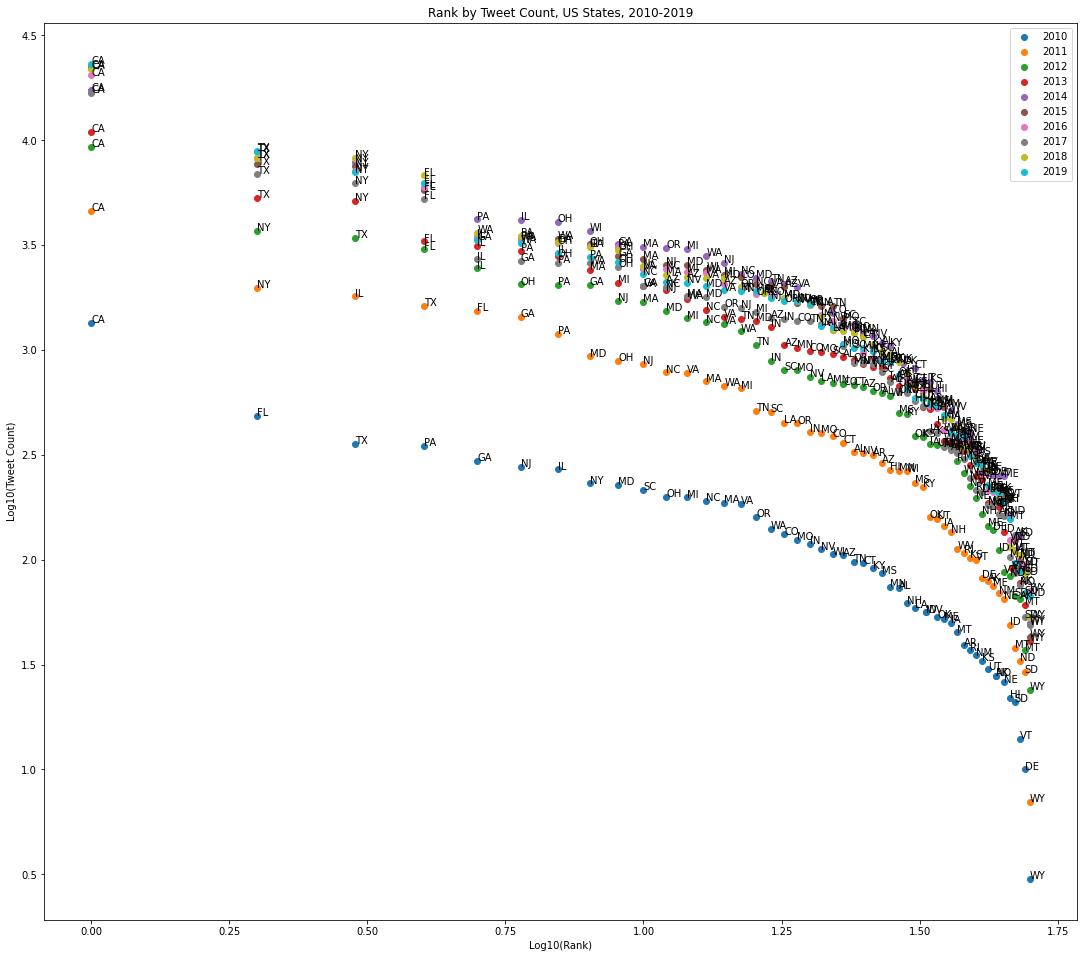

In [42]:
for year in raw_counts_by_state.columns:
  if year != 'Rank' and year != 'State':
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 16.5)
    raw_counts_by_state.sort_values(by=year, ascending = True, inplace = True)
    raw_counts_by_state['Rank'] = raw_counts_by_state[year].rank(ascending = False, method = 'average')
    raw_counts_by_state['State'] = raw_counts_by_state.index
    rawtweetfreqs = raw_counts_by_state[year].value_counts()
    xcoords = [np.log10(x) for x in raw_counts_by_state['Rank']]
    ycoords = [np.log10(y) for y in raw_counts_by_state[year]]
    plt.scatter(xcoords, ycoords, label = year)
    plt.title('Rank by Tweet Count, US States, 2010-2019')
    plt.xlabel('Log10(Rank)')
    plt.ylabel('Log10(Tweet Count)')
    for i, txt in enumerate(raw_counts_by_state['State']):
      plt.annotate(txt, (xcoords[i], ycoords[i]))
    plt.legend()
plt.show()

#   print(frequencies)
  # raw_counts_by_state['Frequencies'] = raw_counts_by_state[year].replace(tweetfreqs, regex = True, inplace = True)
  # print(raw_counts_by_state.head(5), '\n')


#Plots histogram of tweet count distribution across years

In [59]:
raw_counts_by_state.drop(['State', 'Rank'], axis = 'columns', inplace = True) 
raw_counts_by_state.loc[len(raw_counts_by_state)] = [np.sum(raw_counts_by_state[col]) for col in raw_counts_by_state.columns]

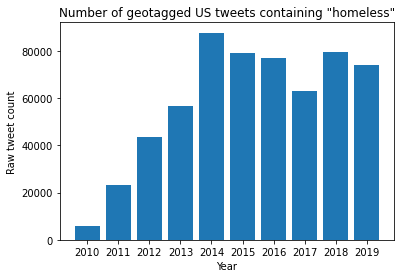

In [60]:
raw_counts_by_state.drop([49, 50, 51], axis = 'rows', inplace = True)
plt.bar(x = raw_counts_by_state.columns, height = raw_counts_by_state.loc[49])
plt.title('Number of geotagged US tweets containing "homeless"')
plt.xlabel('Year')
plt.ylabel('Raw tweet count')
plt.show()


# Generates counts of tweets containing 'homeless' by month for plotting log-odds

In [ ]:
df_w_stateyears['year_month'] = '9999-99'

for index, val in enumerate(df_w_stateyears['created_at']):
  try:
    df_w_stateyears.at[index, 'year_month'] = val[0:7]
  except:
    pass

In [62]:
month_dict = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May', '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}
year_month_dict = {}

for i in range(2010, 2020):
  for key in month_dict.keys():
    yearmonth = str(i) + '-' + key
    year_month_dict[yearmonth] = month_dict[key] + ' ' + str(i)

year_month_dict['9999-99'] ='Unknown'

In [63]:
# df_w_stateyears['year_month'].replace(year_month_dict, inplace = True)

for month in sorted(list(df_w_stateyears['year_month'].value_counts().keys())):
  print(month, df_w_stateyears['year_month'].value_counts()[month])

2010-03 181
2010-04 591
2010-05 606
2010-06 582
2010-07 1186
2010-08 1187
2010-09 914
2010-10 1067
2010-11 1262
2010-12 273
2011-01 306
2011-02 197
2011-03 202
2011-04 2863
2011-05 3119
2011-06 2868
2011-07 2941
2011-08 2961
2011-09 2647
2011-10 3068
2011-11 3752
2011-12 5153
2012-01 5793
2012-02 3821
2012-03 4947
2012-04 3844
2012-05 3196
2012-06 3526
2012-07 4333
2012-08 4761
2012-09 4322
2012-10 4904
2012-11 6266
2012-12 5644
2013-01 5471
2013-02 4119
2013-03 4755
2013-04 4831
2013-05 5252
2013-06 5134
2013-07 2824
2013-08 6152
2013-09 5830
2013-10 6339
2013-11 8302
2013-12 10700
2014-01 10873
2014-02 7751
2014-03 8652
2014-04 7923
2014-05 8073
2014-06 8158
2014-07 8721
2014-08 10347
2014-09 7977
2014-10 7526
2014-11 9615
2014-12 11994
2015-01 10968
2015-02 7655
2015-03 9585
2015-04 7496
2015-05 7541
2015-06 7180
2015-07 8383
2015-08 8157
2015-09 9062
2015-10 8651
2015-11 10554
2015-12 9409
2016-01 9482
2016-02 7837
2016-03 7806
2016-04 7891
2016-05 7732
2016-06 8358
2016-07 8495
20

# StoryWrangler data 2010-2018 for creating log-odds comparison between US-geotagged tweets and English-language tweets containing 'homeless'

In [ ]:
storywrang2018 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2018-01-01_2019-01-01.tsv', sep='\t')
storywrang2017 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2017-01-01_2018-01-01.tsv', sep='\t')
storywrang2016 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2016-01-01_2017-01-01.tsv', sep='\t')
storywrang2015 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2015-01-01_2016-01-01.tsv', sep='\t')
storywrang2014 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2014-01-01_2015-01-01.tsv', sep='\t')
storywrang2013 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2013-01-01_2014-01-01.tsv', sep='\t')
storywrang2012 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2012-01-01_2013-01-01.tsv', sep='\t', engine='c', encoding='latin1')
# storywrang2011 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2011-01-01_2012-01-01.tsv', sep='\t')
storywrang2010 = pd.read_csv('drive/MyDrive/POCS FP/tweets/Storywrangler/2010-01-01_2011-01-01.tsv', sep='\t')

In [ ]:
print(storywrang2018[storywrang2018['ngram'] == 'homeless'])
print(storywrang2018[storywrang2018['ngram'] == 'homelessness'])

          ngram    count  count_no_rt    rank     freq
61843  homeless  2518219       450423  2672.0  0.00003
              ngram   count  count_no_rt     rank      freq
61844  homelessness  370950        71012  11739.0  0.000004


In [ ]:
truly_normalized_totalhomeless = normalized_totalhomeless.copy()
truly_normalized_totalhomeless = (truly_normalized_totalhomeless-truly_normalized_totalhomeless.min())/(truly_normalized_totalhomeless.max()-truly_normalized_totalhomeless.min())

In [ ]:
normalized_percapita_changes_totalhomeless = percapita_changes_unshelteredhomeless.copy()
normalized_percapita_changes_totalhomeless = (normalized_percapita_changes_totalhomeless-normalized_percapita_changes_totalhomeless.min())/(normalized_percapita_changes_totalhomeless.max()-normalized_percapita_changes_totalhomeless.min())

In [ ]:
normalized_percapita_changes_tweets = percapita_changes_tweets.copy()
normalized_percapita_changes_tweets = (normalized_percapita_changes_tweets-normalized_percapita_changes_tweets.min())/(normalized_percapita_changes_tweets.max()-normalized_percapita_changes_tweets.min())

# Generate table of summary statistics for each year of per capita Twitter counts

In [64]:
means = []
std = []
mins = []
max = []
twentyfives = []
medians = []
seventyfives = []
IQRs = []

for col in percapita_tweets.columns:
  means.append(percapita_tweets[col].describe().loc['mean'])
  std.append(percapita_tweets[col].describe().loc['std'])
  mins.append(percapita_tweets[col].describe().loc['min'])
  max.append(percapita_tweets[col].describe().loc['max'])
  twentyfives.append(percapita_tweets[col].describe().loc['25%'])
  medians.append(percapita_tweets[col].describe().loc['50%'])
  seventyfives.append(percapita_tweets[col].describe().loc['75%'])
  IQRs.append(seventyfives[-1]-twentyfives[-1])

summarystats = pd.DataFrame(columns = ['Mean', 'Standard Deviation', 'Variance', 'Minimum', 'Maximum', '25%', 'Median', '75%', 'IQR'], index = percapita_tweets.columns)

for index, val in enumerate(means):
  summarystats.loc[str(2010 + index)] = [means[index], std[index], std[index]**2, mins[index], max[index], twentyfives[index], medians[index], seventyfives[index], IQRs[index]]

print('\n\nSummary statistics of US State-Level Per Capita Tweet Rates\n')

summarystats



Summary statistics of US State-Level Per Capita Tweet Rates



,Mean,Standard Deviation,Variance,Minimum,Maximum,25%,Median,75%,IQR
2010,0.000024,0.000011,0.0,0.000005,0.000047,0.000016,0.000021,0.000031,0.000016
2011,0.000082,0.000038,0.0,0.000012,0.000195,0.00005,0.000079,0.000102,0.000052
2012,0.00015,0.000055,0.0,0.000037,0.00028,0.000116,0.000139,0.000176,0.00006
2013,0.000192,0.000063,0.0,0.00006,0.000359,0.000158,0.000189,0.000225,0.000067
2014,0.000292,0.000124,0.0,0.000086,0.000774,0.000224,0.000276,0.000327,0.000103
2015,0.000267,0.000116,0.0,0.000073,0.000587,0.000205,0.000248,0.000292,0.000087
2016,0.000249,0.000099,0.0,0.000107,0.000521,0.000171,0.000238,0.000297,0.000126
2017,0.000202,0.000089,0.0,0.000061,0.000427,0.000138,0.000194,0.000245,0.000108
2018,0.000255,0.000116,0.0,0.000092,0.000564,0.000187,0.000232,0.000302,0.000115
2019,0.000241,0.000115,0.0,0.000078,0.000678,0.000166,0.000208,0.000292,0.000126


# Plot each state's ranked raw tweet count by their ranked per capita tweet count
Also plots barchart of residuals for each year
(Not plotting correctly)

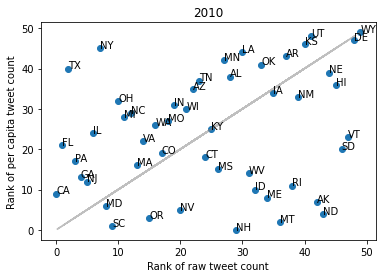

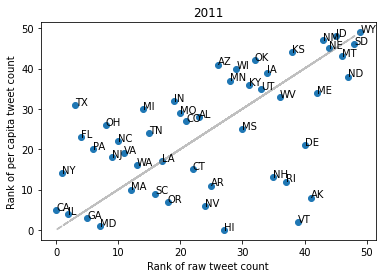

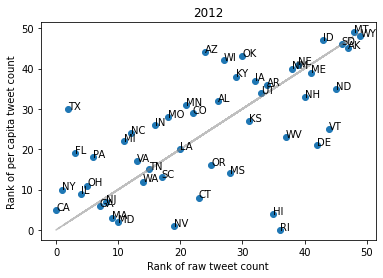

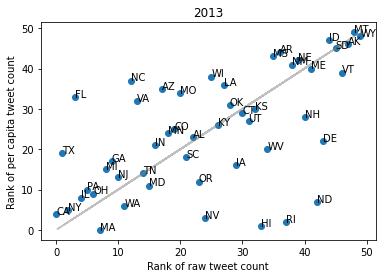

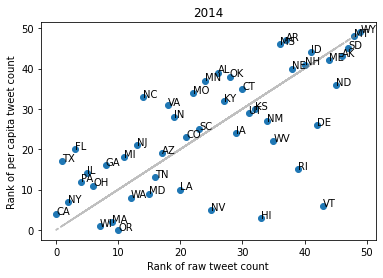

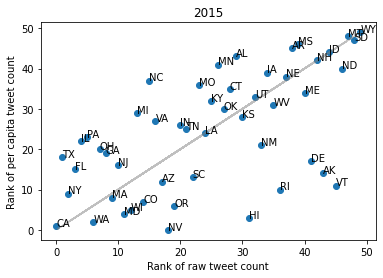

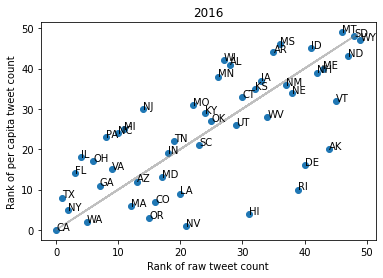

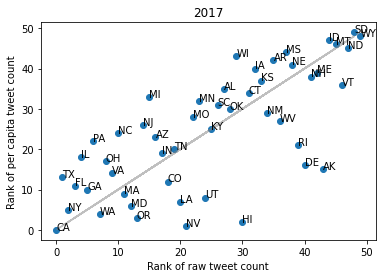

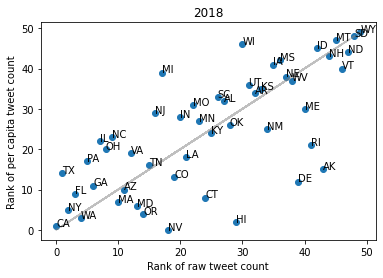

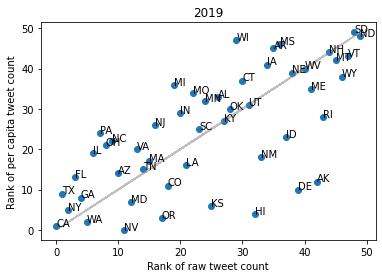

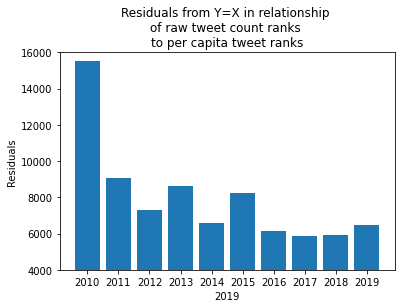

In [73]:
year_distrs = {}

rank_tweet_percentages = rankify(percents_of_tweets)
percapita_tweets_ranked = rankify(percapita_tweets)

for year in raw_counts_by_state.columns:
  year_distrs[year] = {}
  for state in states_without_dc_or_pr:
    year_distrs[year][state] = (rank_tweet_percentages[rank_tweet_percentages[year] == state].index[0], percapita_tweets_ranked[percapita_tweets_ranked[year] == state].index[0])
residuals_points = []

for year in year_distrs.keys():
  basis_for_coords = dict(year_distrs[year].items())
  xcoords = [x[0] for x in basis_for_coords.values()]
  ycoords = [y[1] for y in basis_for_coords.values()]
  markers = [m for m in basis_for_coords.keys()]
  residuals = [y - yhat for y, yhat in zip(ycoords, xcoords)]
  residuals_squared = [res ** 2 for res in residuals]
  residuals_points.append(sum(residuals_squared))
  plt.scatter(xcoords, ycoords, label = year)
  plt.plot(xcoords, xcoords, '--', color = 'gray', alpha = 0.5)
  for index, marker in enumerate(markers):
    plt.annotate(marker, (xcoords[index], ycoords[index]))
  plt.title(year)
  plt.xlabel('Rank of raw tweet count')
  plt.ylabel('Rank of per capita tweet count')
  plt.show()

fig, ax = plt.subplots()
plt.bar(range(10), residuals_points)
plt.title('Residuals from Y=X in relationship \nof raw tweet count ranks \nto per capita tweet ranks')
plt.xlabel(year)
plt.ylim(4000, 16000)
plt.xticks(range(10), range(2010, 2020))
plt.ylabel('Residuals')
plt.show()

In [ ]:
percents_of_tweets = percentize(raw_counts_by_state)

In [ ]:
percents_of_tweets

In [ ]:
percapita_changes_tweets = percapita_changes(percapita_tweets)

# Generate boxplots by year of per capita tweet count data across all states

Text(0.5, 1.0, 'Distribution of Tweet Rates,\nUS States, 2010-2019')

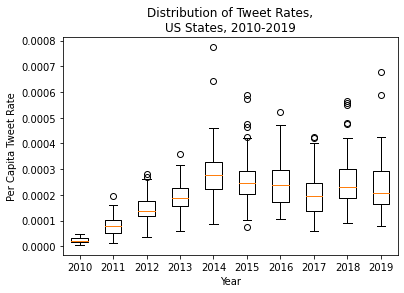

In [74]:
boxplotable_totalhomeless = percapita_tweets.transpose()
fig, ax = plt.subplots()
plt.boxplot(boxplotable_totalhomeless)
ax.set_xticklabels(range(2010, 2020))
plt.xlabel('Year')
plt.ylabel('Per Capita Tweet Rate')
plt.title('Distribution of Tweet Rates,\nUS States, 2010-2019')

In [ ]:
ranked_percapita_tweets = rankify(percapita_tweets)

In [ ]:
ranked_raw_tweets = rankify(raw_counts_by_state)

NameError: ignored

In [ ]:
state_wo_dc_pr_annual_est = state_annual_est.drop(['PR', 'DC'], axis = 'rows')

In [ ]:
normalized_totalhomeless.loc['MA']['2019'] - normalized_totalhomeless.loc['MA']['2018']

-0.00023587549535290016

In [ ]:
persqmi_totalhomeless.loc['MA']['2019'] - persqmi_totalhomeless.loc['MA']['2018']

-0.20474358974358964

In [ ]:
pop_ranks = rankify(state_wo_dc_pr_annual_est)
pop_ranks

In [ ]:
percapita_tweets

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Unnamed: 0,,,,,,,,,,
AK,0.000039,0.000109,0.000089,0.000104,0.000178,0.000289,0.000256,0.000223,0.000279,0.000293
AL,0.000015,0.000068,0.000129,0.000193,0.000222,0.000144,0.000153,0.000144,0.000195,0.000180
AR,0.000013,0.000107,0.000118,0.000118,0.000139,0.000112,0.000135,0.000111,0.000191,0.000134
AZ,0.000016,0.000045,0.000101,0.000159,0.000306,0.000292,0.000297,0.000203,0.000311,0.000289
CA,0.000036,0.000123,0.000246,0.000287,0.000449,0.000572,0.000521,0.000427,0.000556,0.000587
CO,0.000026,0.000076,0.000132,0.000188,0.000281,0.000408,0.000331,0.000245,0.000289,0.000296
CT,0.000027,0.000101,0.000190,0.000181,0.000229,0.000207,0.000198,0.000151,0.000322,0.000166
DE,0.000011,0.000090,0.000152,0.000194,0.000271,0.000285,0.000279,0.000221,0.000307,0.000297
FL,0.000026,0.000081,0.000156,0.000169,0.000294,0.000288,0.000289,0.000251,0.000320,0.000291


In [ ]:
# state_areas = state_areas.drop('DC', axis = 'rows')
densities = state_wo_dc_pr_annual_est / state_areas
density_ranks = rankify(densities)

In [ ]:
for years in normalized_totalhomeless.columns:
  print('\n')
  print(years)
  for states in normalized_totalhomeless.index:
    if normalized_totalhomeless.loc[states][years] > summarystats.loc[years]['75%'] + 1.5 * (summarystats.loc[years]['75%']-summarystats.loc[years]['25%']):
      print(states, pop_ranks[pop_ranks[int(years)] == states].index[0], density_ranks[density_ranks[int(years)] == states].index[0], raw_totalhomeless.loc[states][years])




2010
HI 39 10 5834.0
NV 9 32 11205.0
OR 26 36 19492.0


2011
CA 0 4 125128.0
HI 39 10 6188.0
NV 9 32 9150.0
NY 47 33 63445.0
OR 26 36 17254.0


2012
HI 39 10 6246.0
NY 47 33 69566.0
OR 26 36 15828.0


2013
CA 0 4 118552.0
HI 39 10 6335.0
NY 47 33 77430.0
OR 26 36 13822.0


2014
CA 0 4 113952.0
HI 39 10 6918.0
MA 41 18 21237.0
NV 8 32 8582.0
NY 46 33 80590.0
OR 26 36 12164.0


2015
CA 0 4 115738.0
HI 39 10 7620.0
MA 41 18 21135.0
NV 8 32 8743.0
NY 46 33 88250.0
OR 26 36 13226.0


2016
AK 23 0 1940.0
CA 0 4 118142.0
HI 39 10 7921.0
MA 41 18 19608.0
NV 8 32 7398.0
NY 46 33 86352.0
OR 26 36 13238.0
WA 12 46 20827.0


2017
AK 23 0 1845.0
CA 0 4 131532.0
HI 39 10 7220.0
MA 41 18 17565.0
NV 8 32 7833.0
NY 46 33 89503.0
OR 26 36 13953.0
WA 12 46 21112.0


2018
AK 23 0 2016.0
CA 0 4 129972.0
HI 39 10 6530.0
MA 41 18 20068.0
NV 8 32 7544.0
NY 46 33 91897.0
OR 26 36 14476.0
WA 12 46 22304.0


2019
AK 23 0 1907.0
CA 0 4 151278.0
HI 39 10 6412.0
MA 41 18 18471.0
NV 8 32 7169.0
NY 46 33 92091.0
OR

In [ ]:
for_state_years = Counter(df_w_stateyears['stateyear'])

years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

countsdf = pd.DataFrame(columns=years, index=states_without_dc_or_pr)

for state in states_without_dc_or_pr:
  for year in years:
    thisstateyear = str(tuple([state, year]))
    countsdf.loc[state][year] = for_state_years[thisstateyear]

raw_counts_by_state = countsdf

raw_counts_by_state.to_csv('drive/MyDrive/POCS FP/tweet_counts/raw_counts_by_state.csv')


In [ ]:
xticks = [' ']
for year in ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
  xticks.append(year)
plt.boxplot([percapita_changes_unshelteredhomeless[col] for col in percapita_changes_unshelteredhomeless.columns], showfliers = False)
plt.title('Middle 50% of nationwide distribution of changes to \nunsheltered homelessness counts by state, outliers excluded')
plt.xlabel('Year')
plt.xticks(range(0, 11), xticks)
plt.ylabel('Per capita homelessness rate')
plt.show()

plt.boxplot([percapita_changes_unshelteredhomeless[col] for col in percapita_changes_unshelteredhomeless.columns], showfliers = True)
plt.title('Middle 50% of nationwide distribution of changes \nunsheltered homelessness counts by state, outliers included')
plt.xlabel('Year')
plt.xticks(range(0, 11), xticks)
plt.ylabel('Per capita homelessness rate')
plt.show()

NameError: ignored

In [ ]:
for year in top10homeless_std.columns:
  plt.bar(x = range(1, 11), height = top10homeless_std[year], label = 'Observed data')
  plt.hlines(y = 1.96, xmin = 0, xmax = 11, linestyles = 'dashed', colors = 'r')
  plt.xticks(range(1, 11), top10homeless[year])
  plt.xlabel('Rank')
  plt.ylabel('Standard deviations above national mean')
  plt.title('Z-scores of the 10 states with \nhighest-ranking per capita \n' + str(year) + ' homelessness rate')
  plt.show()


In [ ]:
for year in bottom10homeless.columns:
  plt.bar(x = range(1, 11), height = bottom10homeless_std[year], label = 'Observed data')
  plt.xticks(range(1, 11), bottom10homeless[year])
  plt.hlines(y = 1.96, xmin = 0, xmax = 11, linestyles='dashed', colors = 'r', label='1.96 SD')
  plt.xlabel('Rank')
  plt.ylabel('Standard deviations below national mean')
  plt.title('Z-scores of the 10 states with \n lowest-ranking per capita \n' + str(year) + ' homelessness rate')
  plt.show()

# Creates DataFrame of each state's percentage of each year's geotagged US tweets containing 'homeless'

In [ ]:
# percents_of_tweets = percentize(raw_counts_by_state)
# percents_of_tweets.to_csv('drive/MyDrive/POCS FP/tweets/percents_of_total_twitter_activity.csv')


# Plots ranked distributions of raw tweet volume count by state by year (2x4 subplot)

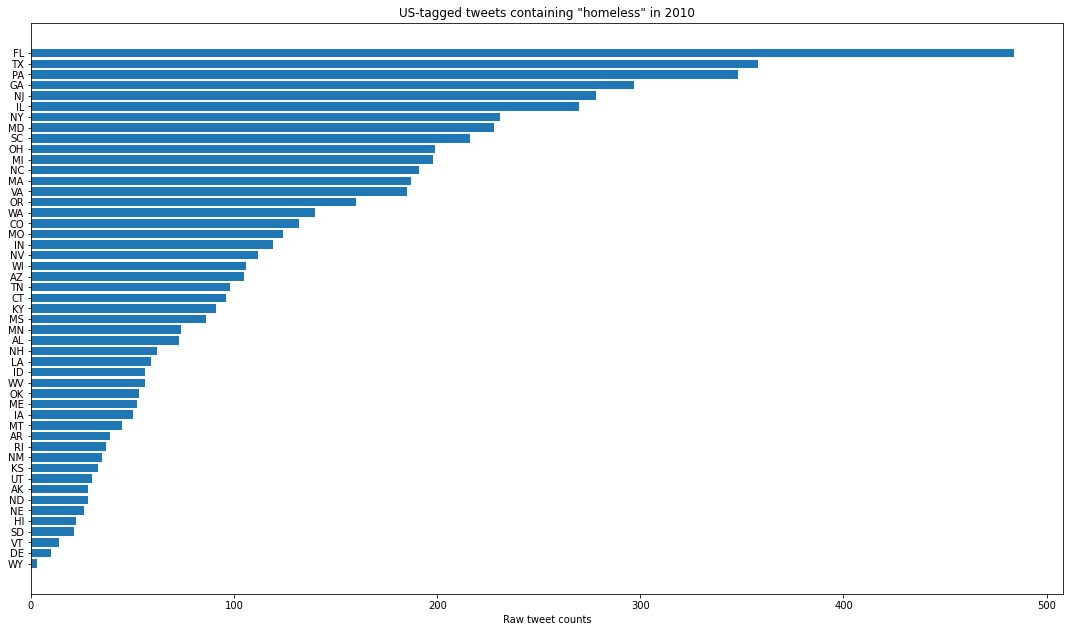

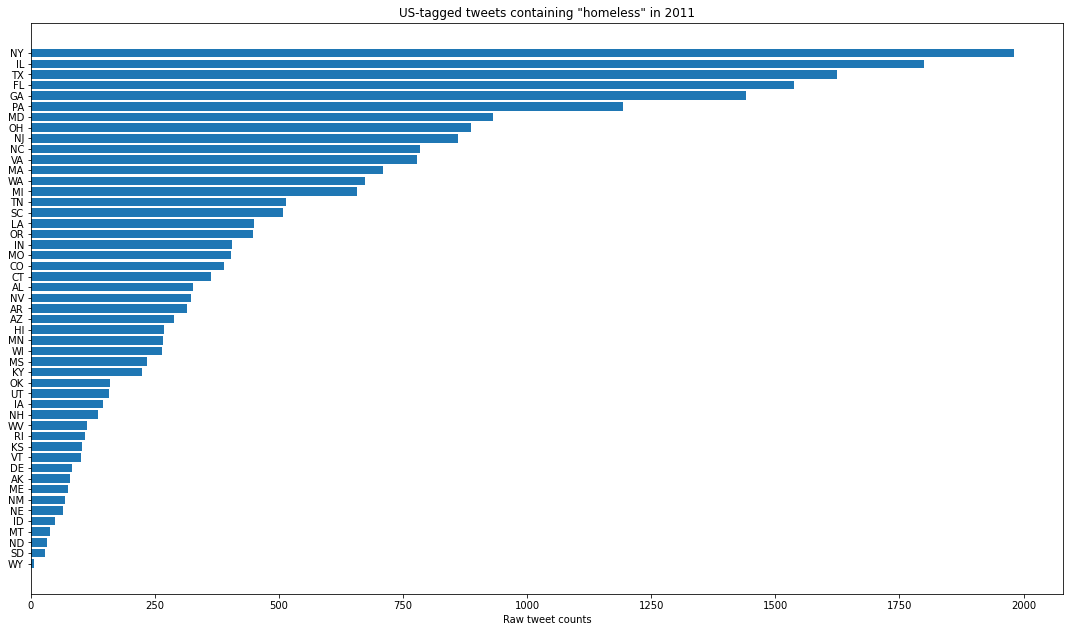

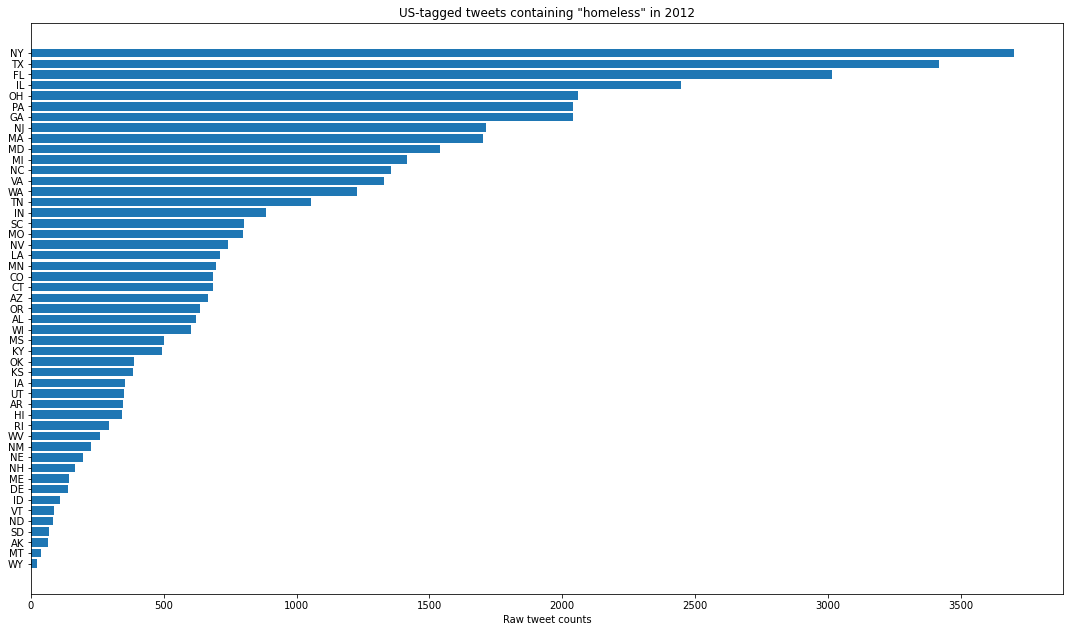

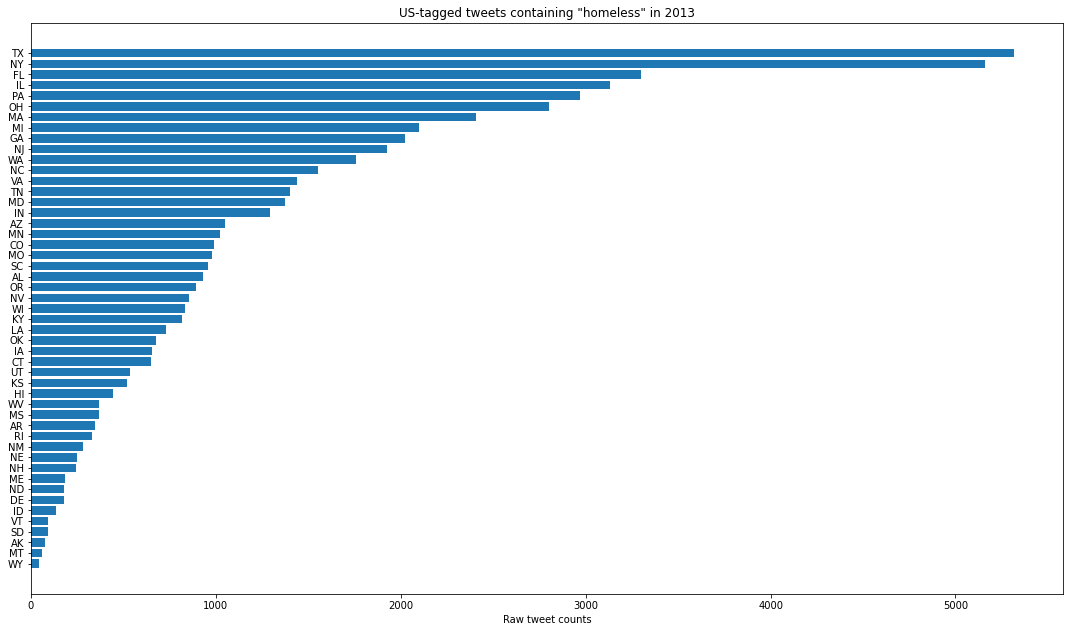

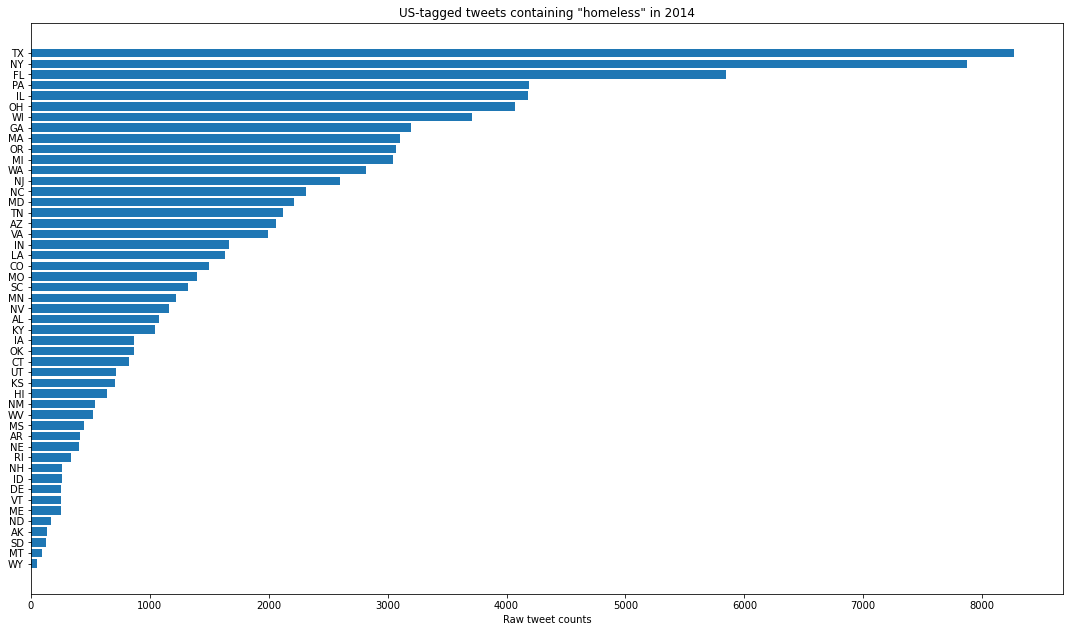

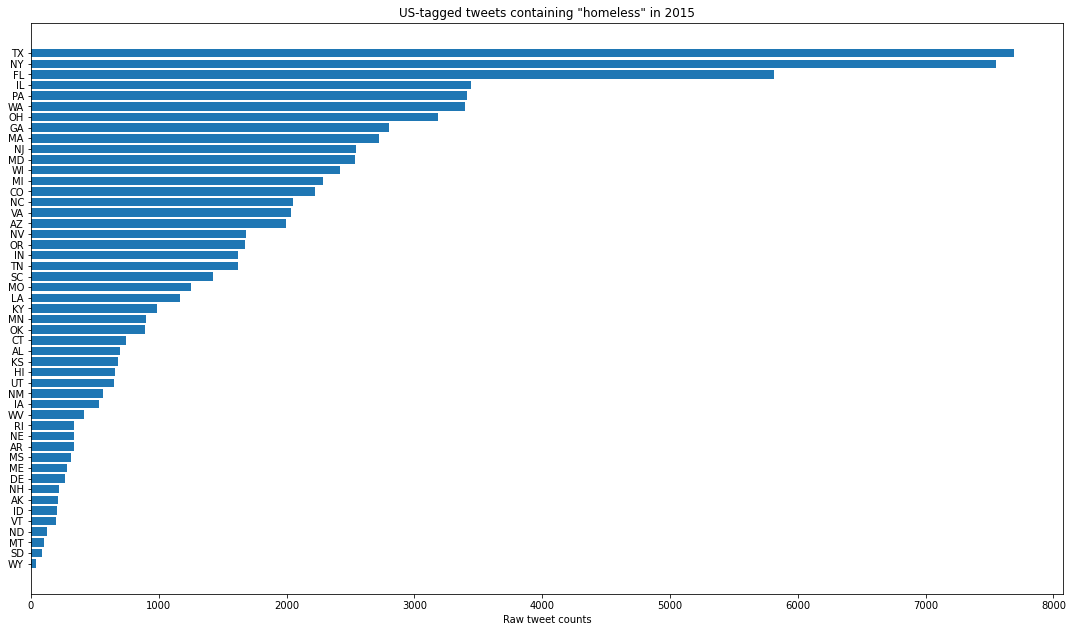

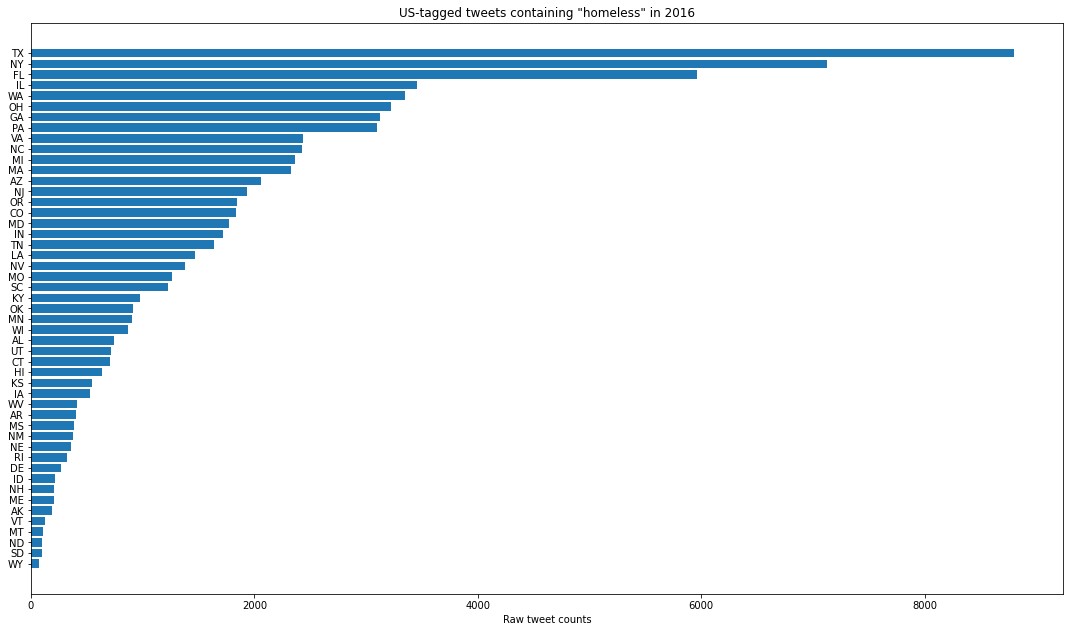

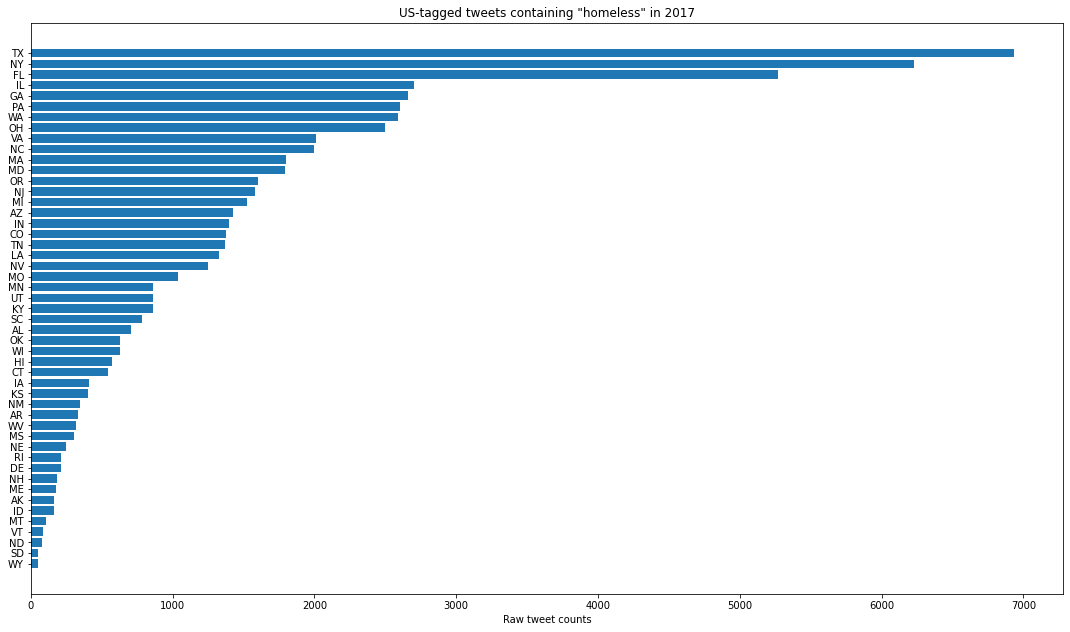

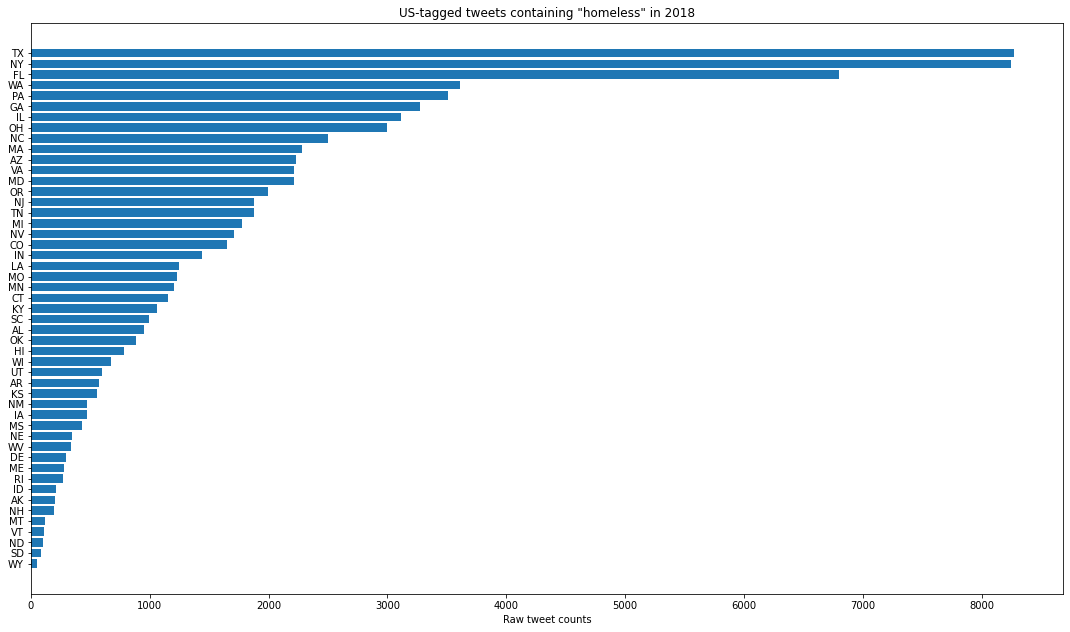

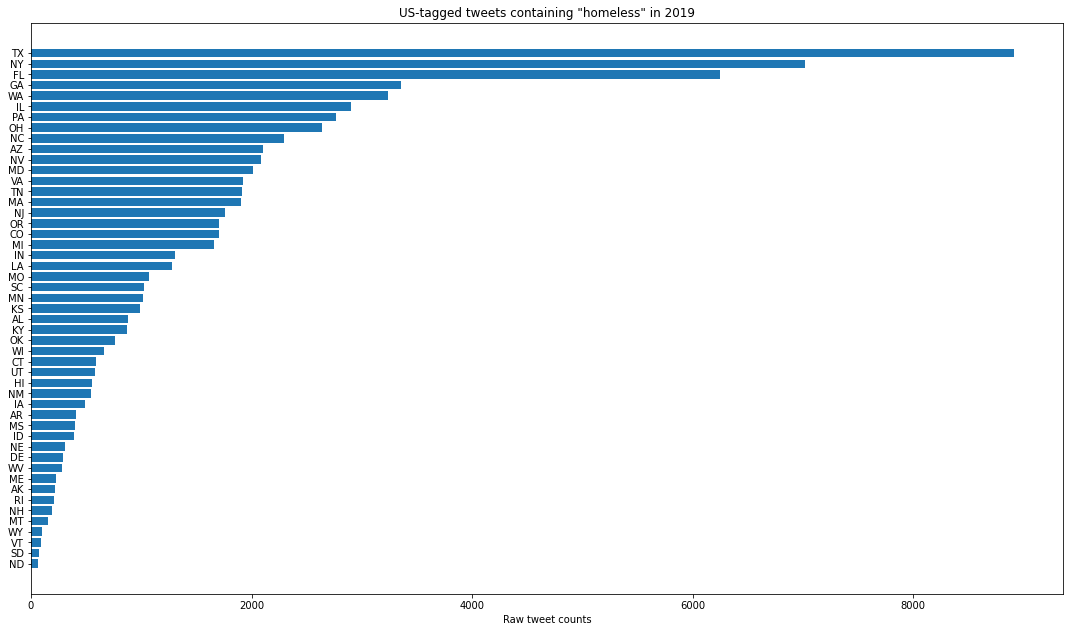

In [82]:
# raw_counts_by_state.drop([49], axis = 'rows', inplace = True)
for year in range(2010, 2020):
  fig = matplotlib.pyplot.gcf()
  fig.set_size_inches(18.5, 10.5)
  counts_by_state = raw_counts_by_state.sort_values(by=str(year), inplace = True)
  plt.barh(y = raw_counts_by_state.index, width = raw_counts_by_state[str(year)])
  plt.title('US-tagged tweets containing "homeless" in '+ str(year))
  plt.xlabel('Raw tweet counts')
  plt.show()

# Calculate variance in per capita tweet rates by state across all years

In [83]:
percapita_tweet_variance = pd.DataFrame(index = percapita_tweets.index, columns = ['Variance'])
tweet_percapita_var = pd.DataFrame(percapita_tweets.var(axis=1), columns = ['Variance'])


In [84]:
tweet_percapita_var

,Variance
Unnamed: 0,
AK,8.931976e-09
AL,3.893656e-09
AR,1.949248e-09
AZ,1.318219e-08
CA,3.877818e-08
CO,1.436086e-08
CT,6.036731e-09
DE,9.846028e-09
FL,1.051740e-08


# *Twitter sentiment analysis EDA*

# Run sentiment analysis on aggregate tweet corpus by state-year

In [ ]:

stops = set(stopwords.words('english'))

# use a subset for debugging purposes
# geotagged_tweets = geotagged_tweets.sample(n = 50000)

# set up the analyzer
labMT, labMTvector, labMTwordList = emotionFileReader(stopval=0.0, lang='english', returnVector=True)


# takes in the concatenated string of all tweets in the group
# returns dictionary of word frequencies for that mega string
def get_frequencies(mega_string):
    # get list of individual words
    words = words_of_tweet(mega_string)
    word_frequencies = Counter(words)     ## This is where I changed the dictionary into a Counter, which is basically a dictionary
    print(word_frequencies)
    return word_frequencies


def group_by_both(df):
    print('Beginning grouping by both')
    e = datetime.datetime.now()
    print("The current time is %s:%s:%s" % (e.hour, e.minute, e.second))
    print()

    states = df['state'].unique()
    years = df['year'].unique()

    # columns for the final dataframe
    states_col = []
    years_col = []
    sentiment_column = []
    raw_sent_column = []

    # loop through all states
    for st in states:
        temp_st = df[df['state'] == st]

        # loop through all years within states
        for yr in years:

            print('Starting ', st, yr)

            # record the current state and year
            states_col.append(st)
            years_col.append(yr)

            # get df of all tweets from that state and year
            temp_tweets = temp_st[temp_st['year'] == yr]

            # concatenate all these tweets into one large string
            year_tweets = ''
            for index in range(0, len(temp_tweets)):
                year_tweets += temp_tweets.iloc[index]['text']
                year_tweets += ' '  # add a space onto the end to avoid tweets merging together

            del (temp_tweets)

            freqs = get_frequencies(year_tweets)

            print(year_tweets[0:1000])

            del (year_tweets)

            this_group_sent = []
            this_group_raw = []

            for key in freqs.keys():
                raw_sent, vec = emotion(key, labMT, shift=True, happsList=labMTvector)
                temp = stopper(vec, labMTvector, labMTwordList, stopVal=1.0)
                sentiment = emotionV(temp, labMTvector)

                this_group_sent.append(sentiment * freqs[key])
                this_group_raw.append(sentiment * freqs[key])

            try:

                sentiment = sum(this_group_sent) / len(this_group_sent)
                raw_sent = sum(this_group_raw) / len(this_group_raw)
                sentiment_column.append(sentiment)
                raw_sent_column.append(raw_sent)

            except:

                sentiment_column.append(-10)
                raw_sent_column.append(-10)

            print('Completed:', st, yr)
            e = datetime.datetime.now()
            print("The current time is %s:%s:%s" % (e.hour, e.minute, e.second))
            print()

    del (temp_st)

    # convert to dictionary and then to dataframe
    state_years_grouped = {'state': states_col, 'year': years_col, 'sentiment': sentiment_column,
                           'raw_sent': raw_sent_column}
    state_years_grouped = pd.DataFrame(state_years_grouped)

    # save the results to a file to move to R
    state_years_grouped.to_csv('state_year_sentiment.csv', index=False)

    del (state_years_grouped)

    print('Completed sentiment analysis for grouping by both')
    e = datetime.datetime.now()
    print("The current time is %s:%s:%s" % (e.hour, e.minute, e.second))


# df = pd.DataFrame(geotagged_tweets.loc[
#                       (geotagged_tweets["state"] != "Puerto Rico") & (geotagged_tweets["state"] != "Unknown") & (
#                                   geotagged_tweets['year'] != "")])

# group_by_both(df)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.7 MB 5.1 MB/s 
  Created wheel for labMTsimple: filename=labMTsimple-2.8.7-py3-none-any.whl size=3792666 sha256=9c92036ce78416e8b9a84ba8e2078a8d168eb1535b3cb3cd210db69e97e02a6f
  Stored in directory: /root/.cache/pip/wheels/a8/8e/e9/8497318bfad7a7b87dbf6dbb4414de7d44cd3fdec53f2cf87e
Successfully built labMTsimple


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang='english', returnVector=True)

df = pd.DataFrame(df.loc[(df["state"]!= "Puerto Rico") & (df["state"] != "Unknown") & (df['year'] != "")])

group_by_both(df)

# Plots state rankings with respect to sentiment analysis by year

In [ ]:
state_year_sentiment = pd.read_csv('drive/MyDrive/POCS FP/state_year_sentiment.csv')

usave = {'2013':5.88, '2011': 5.98, '2012': 5.92}

# for year in state_year_sentiment['year'].unique():
#   if year in usave.keys():
#     state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].sub(usave[year])
#   else:
#     state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].sub(5)
#     state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].truediv(4)

for year in state_year_sentiment['year'].unique():
    state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].sub(5)
    state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].truediv(4)

print(state_year_sentiment)

for year in state_year_sentiment['year'].unique():
  thisstateyear = state_year_sentiment.loc[state_year_sentiment['year'] == year].sort_values(by='sentiment')
  height = thisstateyear['state']
  title = str(year) + ' State Rankings of Aggregate Sentiment'
  plt.barh(range(len(thisstateyear['sentiment'])), thisstateyear['sentiment'])
  plt.title(title)
  plt.xlabel('Sentiment Score')
  plt.yticks(ticks = range(len(thisstateyear['state'])), labels = thisstateyear['state'])
  plt.ylabel('State')
  plt.show()

# Line plot of average US sentiment by year

In [ ]:
state_year_sentiment = pd.read_csv('drive/MyDrive/POCS FP/state_year_sentiment.csv')

usave = {'2013':5.88, '2011': 5.98, '2012': 5.92}

state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].sub(5)
state_year_sentiment['sentiment'] = state_year_sentiment['sentiment'].truediv(4)

xcoords = []
ycoords = []

for year in state_year_sentiment['year'].unique():
  ycoords.append(np.average(state_year_sentiment[state_year_sentiment['year']==year]['sentiment']))
  xcoords.append(int(year))

plt.plot(xcoords, ycoords)
plt.plot([2011, 2012, 2013], [(5.98-5)/4, (5.92-5)/4, (5.88-5)/4])
plt.title('Average ambient sentiment, annualized')
plt.xlabel('Year')
plt.ylabel('Normalized score, range [-1, 1]')
plt.legend(['Tweets containing "homeless"', 'Random sample of all US tweets'])
plt.show()

# *Twitter content/semantic analysis*

# Creates tables for allotaxonometric diagrams
Decreasing-increasing nationwide homelessness
Tweets about 'homeless hair' versus 'homeless pets'
Tweets from embedding groups 35 and 74 

In [ ]:
LH_df, RH_df = prep_allotax(pre2017, post2017)

In [ ]:
pre2017.rename(columns = {'count1':'count'}, inplace = True)
post2017.rename(columns = {'count1': 'count'}, inplace = True)

In [ ]:
pre2017.to_csv('drive/MyDrive/POCS FP/tweet_content/pre2017counts.tsv', sep = '\t')
post2017.to_csv('drive/MyDrive/POCS FP/tweet_content/post2017counts.tsv', sep = '\t')

In [ ]:
hair_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweet_content/hair_tweets.csv', engine = 'c', encoding = 'latin-1')
pets_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweet_content/pets_tweets.csv', engine = 'c', encoding = 'latin-1')

group_35 = pd.read_csv('drive/MyDrive/POCS FP/tweet_content/group35.csv', engine = 'c', encoding = 'latin-1')
group_74 = pd.read_csv('drive/MyDrive/POCS FP/tweet_content/group37.csv', engine = 'c', encoding = 'latin-1')

# hair_tweets.to_csv('drive/MyDrive/POCS FP/tweet_content/LH_hair.tsv', sep = '\t')
# pets_tweets.to_csv('drive/MyDrive/POCS FP/tweet_content/RH_pets.tsv', sep = '\t')

In [ ]:
LH_df, RH_df = prep_allotax(group_35, group_74)

In [ ]:
# LH_df.set_index('Unnamed: 0', drop = True, inplace = True)
# RH_df.set_index('Unnamed: 0', drop = True, inplace = True)
RH_df.rename(columns = {0:'counts'})

# Generates word shift diagram for Groups 35 and 74

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0,

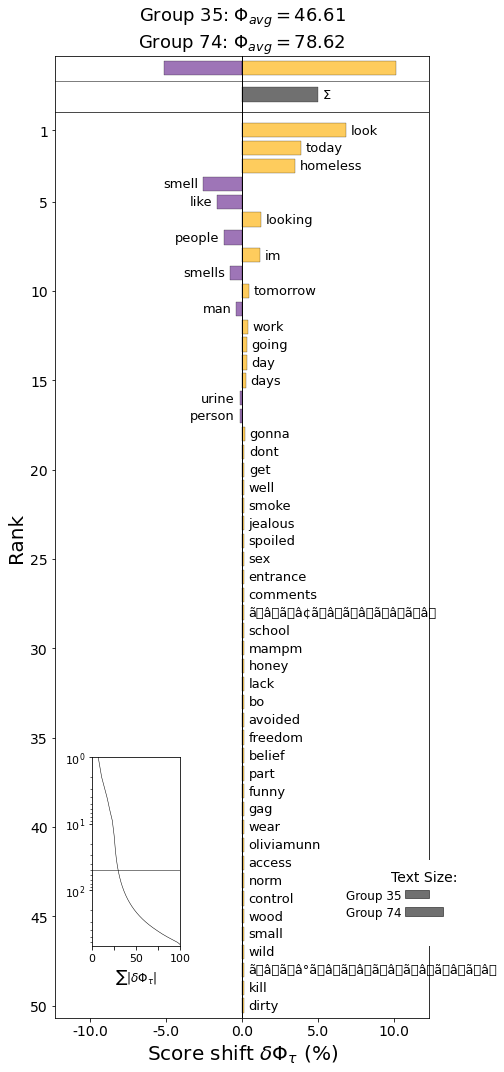

In [ ]:
word_shift(LH_df, RH_df, 0.35, 'Group 35', 'Group 74')

# Prepares groups 1 and 76 tweets from linear embedding for allotaxonometry analysis 

In [ ]:
LH_df, RH_df = prep_allotax(group_1_tweets, group_76_tweets)

In [ ]:
LH_df.to_csv('drive/MyDrive/POCS FP/tweet_content/LH_1.tsv', sep = '\t')
RH_df.to_csv('drive/MyDrive/POCS FP/tweet_content/RH_76.tsv', sep = '\t')

# Word shift for tweets posted in California 2014 versus California 2017

In [ ]:
stops = set(stopwords.words('english'))

excludeme = ["san", "la", "nyc", "sf", "california", "seattle", "los", "losangeles", "oregons", "vegas", "angeles", "francisco", "ca", "redbluff", "las"]

lowratetweets = []
lowratecorpus = []

thisstatetweets = geotagged_tweets[(geotagged_tweets['state'] == 'CA') & (geotagged_tweets['year'] == '2014')]['text']
for tweet in thisstatetweets:
  lowratetweets.append(words_of_tweet(tweet))

for tweet in lowratetweets:
  for word in tweet:
    if word not in excludeme and "http" not in word and word not in stops:
      lowratecorpus.append(word)

lowratecorpuscount = Counter(lowratecorpus)

highratetweets = []
highratecorpus = []

thisstatetweets = geotagged_tweets.loc[(geotagged_tweets['state'] == 'CA') & (geotagged_tweets['year'] == '2017')]['text']
for tweet in thisstatetweets:
    highratetweets.append(words_of_tweet(tweet))

for tweet in highratetweets:
  for word in tweet:
      if word not in excludeme and "http" not in word and word not in stops:
        highratecorpus.append(word)

highratecorpuscount = Counter(highratecorpus)
  
word_shift(lowratecorpuscount, highratecorpuscount, alpha = 0.7, desc1 = 'CA 2014', desc2 = 'CA 2017')



# *Twitter user account analysis*

# Develop dataset of usernames associated with tweets containing 'homeless'

In [ ]:
# all_users = pd.DataFrame(columns = ['id', 'name', 'username'])
# user_indices = random.sample(list(df_w_stateyears.index), 100000)
# counter = 0

# for count in user_indices:
#   try:
#     thisuser = json.loads(df_w_stateyears.loc[count]['author'])
#     all_users.loc[len(all_users)] = [thisuser['id'], thisuser['name'], thisuser['username']]
#     print(counter)
#     counter +=1
#   except:
#     pass

In [ ]:
# print(len(all_users))
# print(all_users.head(100))

In [ ]:
# all_users.drop_duplicates(subset = 'id', keep = 'first', inplace = True, ignore_index = True)
# temp = all_users['username']
# print(len(all_users))
# temp.replace(user_tweet_counts, inplace = True)
# all_users['counts'] = temp

# print(all_users.head(100))

In [ ]:
# all_users.to_csv('drive/MyDrive/POCS FP/users_analysis/all_users.csv')

# **SECTION FIVE: ANALYSIS OF DEPENDENCIES/CROSS-CORRELATIONS**

# *Homelessness, Twitter volume*

# Boxplots of distributions for all 50 states of per capita tweet rates, per capita homelessness rates, per square mile homelessness densities

In [ ]:
# percapita_tweets.set_index('Unnamed: 0', drop = True)

xlabels = ['']
for val in percapita_tweets.index:
  xlabels.append(val)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 19.5)
axes = fig.subplots(3,1)
axes[0].boxplot(percapita_tweets)
axes[0].set_title('Distribution of Tweet Rates by State, 2010 - 2019')
axes[0].set_ylabel('Per Capita Tweet Rate')
axes[0].set_xticklabels(states_without_dc_or_pr)
# axes[0].hlines(median_median_tweets, 1, 50, linestyle = 'dashed', colors = 'red')
plt.xlabel('State')

axes[1].boxplot(normalized_totalhomeless)
axes[1].set_title('Distribution of Homelessness Rates by State, 2010 - 2019')
axes[1].set_ylabel('Per Capita Total Homelessness Rate')
axes[1].set_xticklabels(states_without_dc_or_pr)
# axes[1].hlines(median_median_homeless, 1, 50, linestyle = 'dashed', colors = 'red')

axes[2].boxplot(persqmi_totalhomeless)
axes[2].set_title('Distribution of Homelessness Density by State, 2010 - 2019')
axes[2].set_ylabel('Total Homelessness Count Per Square Mile (Land)')
axes[2].set_xticklabels(states_without_dc_or_pr)
# axes[2].hlines(median_median_homeless, 1, 50, linestyle = 'dashed', colors = 'red')
plt.show()

In [ ]:
# print(state_annual_est)

years = [str(x) for x in range(2010, 2020)]

normalized_geotagged_tweets_by_year = pd.DataFrame(columns = years, index = states_without_dc_or_pr)
log_normalized_geotagged_tweets_by_year = pd.DataFrame(columns = years, index=states_without_dc_or_pr)

state_annual_est_dict = dict(state_annual_est)

for state in states_without_dc_or_pr:
    try:
        normalized_geotagged_tweets_by_year.loc[state] = raw_counts_by_state.loc[state]
        log_normalized_geotagged_tweets_by_year.loc[state] = raw_counts_by_state.loc[state]
    except:
        print(state)

for state in normalized_geotagged_tweets_by_year.index.values:
  for year in normalized_geotagged_tweets_by_year.columns:
    normalized_geotagged_tweets_by_year.at[state, year] = normalized_geotagged_tweets_by_year.loc[state][year]/state_annual_est_dict[int(year)][state]
    log_normalized_geotagged_tweets_by_year.at[state, year] = np.log10(log_normalized_geotagged_tweets_by_year.loc[state][year]/state_annual_est_dict[int(year)][state])

normalized_geotagged_tweets_by_year.to_csv('drive/MyDrive/POCS FP/tweets/percapita_tweets')

Cheat sheet of objects to speed up conversion between states and postal codes

In [ ]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46', 'Puerto Rico': '72'
}

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'Puerto Rico']

us_state_to_abbrev = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
          "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
          "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL",
          "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
          "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI",
          "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
          "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
          "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
          "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
          "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
          "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
          "Wisconsin": "WI", "Wyoming": "WY",
          "Puerto Rico": "PR",
          "District of Columbia": "DC",
          # "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP",
          # "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"
}

us_abbrev_to_state = dict(map(reversed, us_state_to_abbrev.items()))
us_abbrev_to_state['Puerto Rico'] = 'Puerto Rico'
statenames = sorted(us_state_to_abbrev.keys())
states_without_dc_or_pr = [state for state in states if state != 'DC' and state != 'Puerto Rico']
states_without_pr = [state for state in states if state != 'Puerto Rico']

One Year Population Estimates 2010-2019 data

In [ ]:
state_annual_est = pd.read_excel('drive/MyDrive/POCS FP/population/nst-est2019-01.xlsx', usecols='A, B,D:M', engine='openpyxl', skiprows=[0, 1, 2, 4, 5, 6, 7, 8, 60, 62, 63, 64, 65, 66])

for index, state in enumerate(state_annual_est['Unnamed: 0']):
    if '.' == state_annual_est.loc[index]['Unnamed: 0'][0]:
        state_annual_est.at[index, 'Unnamed: 0'] = us_state_to_abbrev[state_annual_est.loc[index]['Unnamed: 0'][1::]]
    else:
        state_annual_est.at[index, 'Unnamed: 0'] = us_state_to_abbrev[state_annual_est.loc[index]['Unnamed: 0']]

state_annual_est.set_index(keys = 'Unnamed: 0', inplace = True, drop = True)


National population estimates by year

In [ ]:
nation_annual_est_pop = pd.DataFrame(columns = state_annual_est.columns)
nation_annual_est_pop.loc[len(nation_annual_est_pop)] = [sum(state_annual_est[col]) for col in state_annual_est.columns]

Homelessness data tables from HUD (also groups CoC-level observations by states)

In [ ]:
# DataFrame of raw counts of total homeless by state-year
raw_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/raw_totalhomeless.csv', engine = 'c', encoding = 'latin1')
raw_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of per capita counts of total homeless by state-year
normalized_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/normalized_total.csv', engine='c', encoding='latin1')
normalized_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of per capita counts of unsheltered homeless by state-year
normalized_unshelteredhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/normalized_unsheltered.csv', engine='c', encoding='latin1')
normalized_unshelteredhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of log-transformed per capita counts of unsheltered homeless by state-year
lognormal_unshelteredhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/lognormal_unsheltered.csv', engine = 'c', encoding='latin1')
lognormal_unshelteredhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of log-transformed per capita counts of total homeless by state-year
lognormal_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/lognormal_total.csv', engine = 'c', encoding = 'latin1')
lognormal_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of total homeless density (persons per square land mile) by state-year
persqmi_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/persqmi_homeless.csv', engine = 'c', encoding = 'latin1')
persqmi_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame of all 3/1/2010 - 12/31/2019 tweets including state-year column
df_w_stateyears = pd.read_csv('drive/MyDrive/POCS FP/tweets/all_geotagged_tweets_w_stateyears.csv', engine='c', encoding='utf-8', usecols = ['id', 'text', 'created_at', 'author_id', 'author', 'geo', 'year', 'bbox', 'exact_coordinates', 'state', 'place_type', 'full_name', 'stateyear'])

# DataFrame of per capita changes in total homelessness between consecutive years by state-year
percapita_changes_totalhomeless = pd.read_csv('drive/MyDrive/POCS FP/homelessness/percapita_changes_totalhomeless.csv')

# DataFrame of raw tweet counts by state-year
raw_counts_by_state = pd.read_csv('drive/MyDrive/POCS FP/tweet_counts/raw_counts_by_state.csv', engine = 'c', encoding = 'latin-1')
raw_counts_by_state.set_index(keys = 'Unnamed: 0', drop = True, inplace = True)

# DataFrame of per capita tweet counts by state-year
percapita_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweets/percapita_tweets', engine = 'c', encoding = 'latin-1')
percapita_tweets.set_index(keys = 'Unnamed: 0', drop = True, inplace = True)

# DataFrame of proportion of state-year tweets to total nation-year tweets 
percents_of_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweets/percents_of_total_twitter_activity.csv', engine='c', encoding='latin1')
percents_of_tweets.set_index("Unnamed: 0", drop = True, inplace = True)

# DataFrame of per capita changes in raw tweet counts between consecutive years by state-year
changes_percapita_tweets = pd.read_csv('drive/MyDrive/POCS FP/tweet_counts/changes_percapita', engine = 'c', encoding = 'latin-1')
changes_percapita_tweets.set_index('Unnamed: 0', drop = True, inplace = True)

# DataFrame from dictionary of counts for tokens in tweets during years of 
# nationwide decreasing vs. increasing homelessness - count1 = 2010-2015, 
# count2 = 2016-2019  
allyears = pd.read_csv('drive/MyDrive/POCS FP/tweet_content/allyears.csv', engine = 'c', encoding = 'latin-1')
allyears.set_index('Unnamed: 0', drop = True, inplace = True)
allyears.drop(0, axis = 'rows')


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,token,count1,count2
Unnamed: 0,,,
1,hunid,1.0,0.0
2,deadend,0.0,4.0
3,fuckyeahhhh,1.0,0.0
4,bebeand,1.0,0.0
5,tryinn,1.0,0.0
...,...,...,...
461522,mcad,0.0,3.0
461523,3976,1.0,0.0
461524,darri,5.0,0.0


Generates DataFrames of token counts for 2010-2015 and for 2016-2020

In [ ]:
# pre2017 = allyears[allyears['count1'] != 0][['token', 'count1']]
# post2017 = allyears[allyears['count2'] != 0][['token', 'count2']]

# pre2017.rename(columns = {'count1': 'count'}, inplace = True)
# pre2017.set_index('token', drop = True, inplace = True)
# post2017.rename(columns = {'count2': 'count'}, inplace = True)
# post2017.set_index('token', drop = True, inplace = True)

# pre2017.to_csv('drive/MyDrive/POCS FP/tweet_content/pre2017.tsv', sep = '\t')
# post2017.to_csv('drive/MyDrive/POCS FP/tweet_content/post2017.tsv', sep = '\t')

Assigns rank column to DataFrame of decreasing-increasing homelessness counts

In [ ]:
# pre2017['rank'] = pre2017['count'].rank(method = 'average', ascending = False)

In [ ]:
# post2017['rank'] = post2017['count'].rank(method = 'average', ascending = False)

*Homelessness Volume, Tweet Volume*

# Plot percent of tweets as function of homelessness density

In [ ]:
for year in persqmi_totalhomeless.columns:
  plt.scatter(persqmi_totalhomeless[year], percents_of_tweets[year])
  plt.title(year)
  plt.show()

# Line plots of per capita homeless count and per capita tweet count for individual states across all years of data

In [ ]:
# plt.plot(normalized_totalhomeless.columns, normalized_totalhomeless.loc['TX'], label = 'TX')
# plt.plot(normalized_totalhomeless.columns, normalized_totalhomeless.loc['CA'], label = 'CA')
# plt.plot(normalized_totalhomeless.columns, normalized_totalhomeless.loc['NY'], label = 'NY')
# plt.legend()
# plt.show()

# plt.plot(percapita_tweets.columns, percapita_tweets.loc['TX'], label = 'TX')
# plt.plot(percapita_tweets.columns, percapita_tweets.loc['WA'], label = 'WA')
# plt.plot(percapita_tweets.columns, percapita_tweets.loc['NY'], label = 'NY')
# plt.legend()
# plt.show()

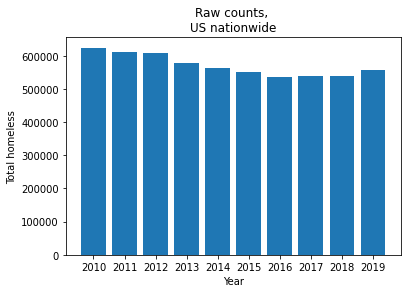

In [ ]:
plt.bar(raw_totalhomeless.columns, [sum(raw_totalhomeless[col]) for col in raw_totalhomeless.columns])
plt.title('Raw counts, \nUS nationwide')
plt.xlabel('Year')
plt.ylabel('Total homeless')
plt.show()

# Plots Twitter data as a function of homelessness counts (with linear regression)

In [ ]:
for year in range(2010, 2018):
    xcoords = []
    ycoords = []
    for state in states_without_dc:
        if np.isfinite(lognormal_totalhomeless.loc[state][str(year)]) and np.isfinite(log_normalized_tweet_counts_by_state_by_year.loc[state][str(year)]):
            xcoords.append(lognormal_totalhomeless.loc[state][str(year)])
            ycoords.append(log_normalized_tweet_counts_by_state_by_year.loc[state][str(year)])
    lm = sklearn.linear_model.LinearRegression().fit(np.array(xcoords).reshape(-1, 1), ycoords)
    lr_coords.append(round(float(lm.coef_), 2))
    plt.scatter(xcoords, ycoords)
    plt.plot(xcoords, lm.predict(np.array(xcoords).reshape(-1, 1)), '--', color = 'gray')
    plt.xlabel('Log10(Normalized total homeless count)')
    plt.ylabel('Log10(Normalized tweet volume)')
    plt.title(str(year) + ' tweet volume as a function of \nstate total homelessness per capita')
    plt.legend(['Observations', 'Linear regression, slope = ' + str(round(float(lm.coef_), 2))])
    plt.show()


# Plotting CA reported homelessness, tweets, proportion of all tweets containing "homeless" over time

In [ ]:
plt.bar(x = countsdf.columns, height = countsdf.loc['CA'])
plt.title('CA tweets containing "homeless" over time')
plt.xlabel('Year')
plt.ylabel('Count of tweets')
plt.show()

plt.bar(x = raw_totalhomeless.columns, height = raw_totalhomeless.loc['CA'])
plt.title('CA reported homelessness over time')
plt.xlabel('Year')
plt.ylabel('Count of homeless individuals')
plt.show()

tweet_state_proportions = pd.DataFrame(columns = years, index = states_without_dc_or_pr)

for state in countsdf.index.values:
  for year in countsdf.columns:
    tweet_state_proportions.at[state, year] = countsdf.loc[state][year] / sum(countsdf[year])
  
plt.bar(x=tweet_state_proportions.columns, height=tweet_state_proportions.loc['CA'])
plt.title('CA as proportion of all geotagged US tweets containing "homeless"')
plt.xlabel('Year')
plt.ylabel('CA tweets / US tweets')
plt.show()


# Calculate median values by year for per capita tweet rates, per capita total homeless counts, and raw homeless counts
Also takes median of the median values across all years' medians for the raw and per capita homeless counts

In [ ]:
median_tweets = np.median(percapita_tweets)
median_homeless = np.median(normalized_totalhomeless)
median_median_homeless = np.median(median_homeless)
median_median_tweets = np.median(median_tweets)
median_raw = np.median(raw_totalhomeless)
median_median_raw = np.median(median_raw)

# Calculate Pearson statistics for per capita homeless rates against state proportion of tweet totals for year

In [ ]:
print('Pearson stats for total homeless per capita ranks v tweet percentages ranks\n\n')
corr_df = Pearson_stats(persqmi_totalhomeless, percents_of_tweets, states_without_dc_or_pr, False)

In [ ]:
corr_df[0]

# Plot Pearson coefficients for correlation between homelessness density and Twitter volume across all years

In [ ]:
xcoords = [int(x) for x in persqmi_totalhomeless.columns]
pearsoncoef = corr_df[0]['Pearson coef']
pearsonp = corr_df[0]['Pearson p-value']

fig, ax = plt.subplots()
plt.plot(xcoords, pearsoncoef, label = "Pearson coefficient")
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('Correlation between homelessness \n and homelessness-related Twitter activity')
plt.xlabel('Year')
plt.ylabel('Pearson coefficient')
ax2 = ax.twinx()
plt.ylabel('p-value')
plt.plot(xcoords, pearsonp, color = 'orange', label = 'p-value')
plt.legend(bbox_to_anchor=(1.1, 0.9), loc='upper left')
plt.show()

In [ ]:
bottom10s = {}

## GET TOP TEN LISTS OF NORMALIZED TOTAL HOMELESSNESS RATES BY STATE

for year in range(2010, 2020):
  thisyear = normalized_totalhomeless[str(year)][0:-1]
  rankings = thisyear.sort_values(ascending = True)
  thiscolumn = rankings.index.values[0:10]
  bottom10s[str(year)]  = thiscolumn
  bottom10homeless = pd.DataFrame.from_dict(bottom10s, orient = "columns")

bottom10homeless

,2010,2011,2012,2013,2014,2015,2016,2017
0,KS,MS,MS,MS,MS,MS,MS,MS
1,SD,KS,KS,KS,VA,KS,KS,LA
2,MS,ND,IA,VA,KS,AL,VA,VA
3,AR,IN,IN,IN,IN,VA,WV,WV
4,SC,SD,ND,AL,AL,AR,AR,KS
5,IA,WI,VA,IA,DE,TX,TX,AL
6,IN,RI,SD,DE,AR,LA,AL,SC
7,OH,IA,SC,IL,LA,IN,LA,IN
8,DE,VA,WI,WI,IA,OH,IN,AR
9,WI,IL,AL,OH,IL,OK,OH,TX


# Plot max per capita homeless rate against max tweet rate or tweet rate variance

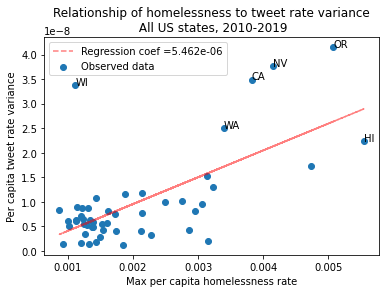

In [ ]:
maxpercapita_totalhomeless = {}
for state in normalized_totalhomeless.index:
  maxpercapita_totalhomeless[state] = (max(normalized_totalhomeless.loc[state]), np.var(percapita_tweets.loc[state]))

xcoords = np.array([x[0] for x in maxpercapita_totalhomeless.values()])
ycoords = pd.Series([y[1] for y in maxpercapita_totalhomeless.values()])


lr = sk.linear_model.LinearRegression()
lr.fit(np.array(xcoords).reshape(50, 1), ycoords)

plt.scatter(xcoords, ycoords, label = 'Observed data')
plt.plot(np.array(xcoords).reshape(50, 1), lr.predict(np.array(xcoords).reshape(50, 1)), '--', color = 'r', alpha = 0.5, label = 'Regression coef =' + str(round(float(lr.coef_), 9)))
plt.legend()
for key, val in maxpercapita_totalhomeless.items():
  if val[1]>(2.0 * 10 ** (-8)):
    plt.annotate(key, (val[0], val[1]))
plt.title('Relationship of homelessness to tweet rate variance\n All US states, 2010-2019')
plt.xlabel('Max per capita homelessness rate')
plt.ylabel('Per capita tweet rate variance')
plt.show()


# Generates boxplot of distributions of cross-correlation coefficients between per capita homelessness and tweet rate time series for each year of data

In [ ]:
corr_df = cross_correlate(percapita_changes_totalhomeless, percapita_changes_tweets)

[1, 2, 3, 4, 5, 6, 7, 8]


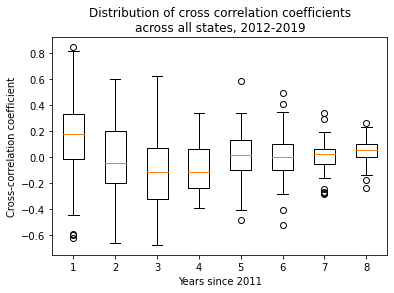

In [ ]:
years = sorted(list(corr_df.keys()))
print(years)

xcoords = years
ycoords = [corr_df[year] for year in xcoords]

plt.boxplot(ycoords)
plt.title('Distribution of cross correlation coefficients\nacross all states, 2012-2019')
plt.xlabel('Years since 2011')
plt.ylabel('Cross-correlation coefficient')
plt.show()

In [ ]:
print('Pearson correlation analysis of each state\'s annualized per capita changes in \ntotal homeless count (from Year X-1 to Year X) and its percent of tweets')

pearson_df, stat_sig_states = Pearson_stats(percapita_changes_totalhomeless, percapita_changes_tweets, states_without_dc_or_pr, columns = False)

print(stat_sig_states)
pearson_df

# plt.gcf()
# fig = plt.Figure()
# # fig.set_size_inches(18.5, 6.5)

# for state in states_without_dc_or_pr:
#   plt.scatter(percapita_changes_totalhomeless.loc[state], percapita_changes_tweets.loc[state])
#   plt.title(state)
#   plt.show()

# fig, axes = plt.subplots(nrows = 2, ncols =5)

# fig.set_size_inches(18.5, 16.5)
# for index, year in enumerate(percapita_changes_totalhomeless.columns):
#   if index < 5:
#     axes[0, index].scatter(percapita_changes_totalhomeless[year], percents_of_tweets[year])
#     axes[0, index].set_xlabel('Per capita changes total homeless')
#     axes[0, index].set_ylabel('Percents of tweets')
#     axes[0, index].set_title(year)
#     axes[0, index].annotate(percents_of_tweets[year].idxmax(), (max(percapita_changes_totalhomeless[year]), max(percents_of_tweets[year])))
#   else:
#     axes[1, index - 5].scatter(percapita_changes_totalhomeless[year], percents_of_tweets[year])
#     axes[1, index-5].set_xlabel('Per capita changes total homeless')
#     axes[1, index-5].set_ylabel('Percents of tweets')
#     axes[1, index-5].set_title(year)
#     axes[1, index-5].annotate(percents_of_tweets[year].idxmax(), (max(percapita_changes_totalhomeless[year]), max(percents_of_tweets[year])))

# plt.suptitle('Relationship of per capita changes in total homelessness \nsince prior year to percent of tweets')
# plt.show()

# plt.scatter(percapita_changes_totalhomeless['2017'], percents_of_tweets['2017'])
# plt.show()
# plt.scatter(percapita_changes_totalhomeless['2019'], percents_of_tweets['2019'])
# plt.show()


In [ ]:
# ave_normalized_totalhomeless = []

# for state in normalized_totalhomeless.index:
#   ave_normalized_totalhomeless.append(np.average(normalized_totalhomeless.loc[state]))

# pearson_df['Average rate'] = ave_normalized_totalhomeless

# pearson_df['Average rate rank'] = pearson_df['Average rate'].rank(method = 'average', ascending = False)

# pearson_df['Average Pearson coef rank'] = pearson_df['Pearson coef'].rank(method = 'average', ascending = False)

# pearson_df = pearson_df.sort_values(by = 'Average rate rank')

pearson_df = pearson_df.sort_values(by = 'Pearson p-value')
pearson_df

# Line plots of anti-correlated homelessness and tweet rates across all years for a single state (TX)

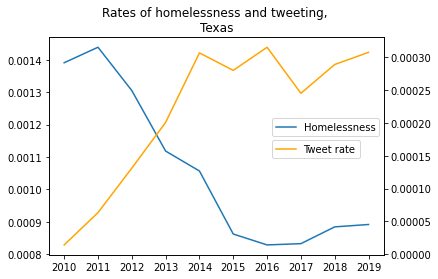

In [ ]:
state = 'TX'

fig, ax = plt.subplots()
plt.title('Rates of homelessness and tweeting, \nTexas')
ax.plot(normalized_totalhomeless.columns, normalized_totalhomeless.loc[state], label = 'Homelessness')
plt.legend(bbox_to_anchor=(0.65, 0.65), loc='upper left')
ax2 = ax.twinx()
ax2.plot(percapita_tweets.columns, percapita_tweets.loc[state], color = 'orange', label = 'Tweet rate')
plt.legend(bbox_to_anchor=(0.65, 0.55), loc='upper left')
plt.show()

# xcoords = range(1, 9)
# for x in xcoords:
#   if corr_df2[x][0] == state:
#     ycoords.append(corr_df2[x][1])

# plt.plot(xcoords, ycoords)

# *Tweet sentiment, homelessness volume*

#Plots state sentiment as a function of homelessness rate

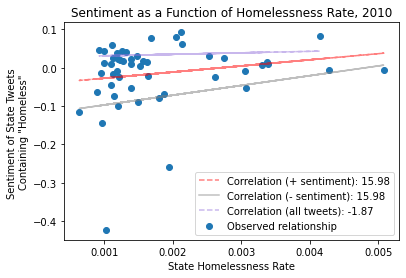

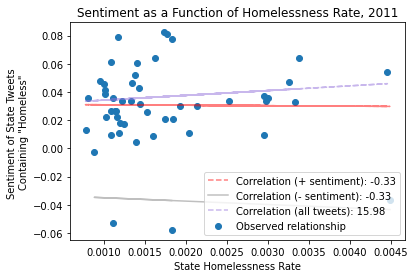

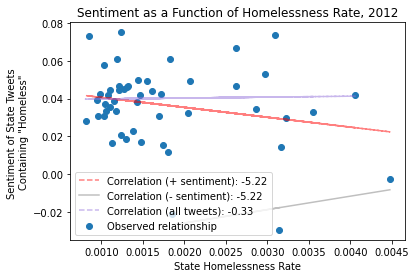

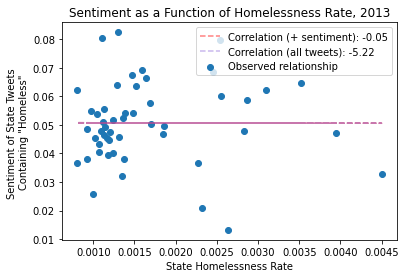

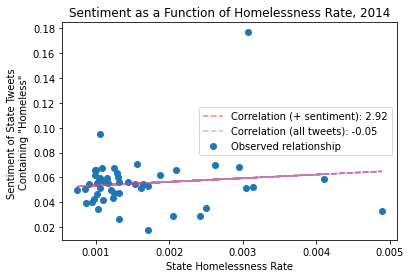

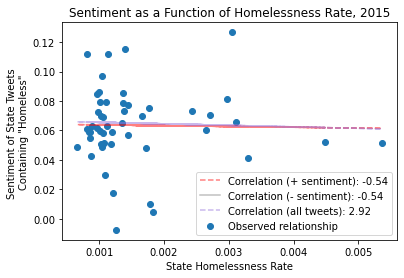

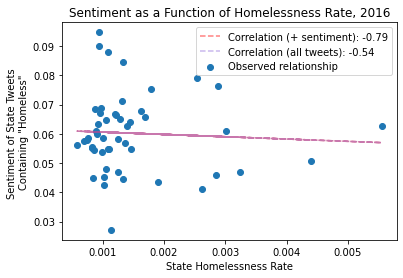

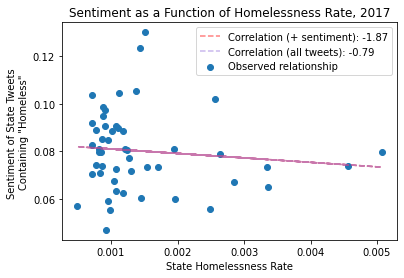

In [ ]:
for year in range(2010, 2018):
  xcoords = []
  ycoords = []
  negycoords = []
  posycoords = []
  negxcoords = []
  posxcoords = []
  for state in states_without_dc_or_pr:
      ycoord = state_year_sentiment[(state_year_sentiment['state'] == state) & (state_year_sentiment['year'] == year)]['sentiment'].tolist()
      # print(ycoord)
      xcoord = normalized_totalhomeless.loc[state][str(year)]
      if np.isfinite(normalized_totalhomeless.loc[state][str(year)]) and np.isfinite(normalized_tweet_counts_by_state_by_year.loc[state][str(year)]):
          xcoords.append(xcoord)
          ycoords.append(ycoord[0])
      try:
        if ycoord[0] < 0:
          negxcoords.append(xcoord)
          negycoords.append(ycoord[0])
        if ycoord[0] > 0:
          posxcoords.append(xcoord)
          posycoords.append(ycoord[0])
      except:
        print('Error with: ', state, year)

  legendlabels = ['Observed relationship', 'Correlation (all tweets): ' +str(round(float(lr.coef_), 2))]
      
  plt.title('Sentiment as a Function of Homelessness Rate, ' + str(year))
  plt.scatter(xcoords, ycoords)
  lr = sk.linear_model.LinearRegression().fit(np.array(xcoords).reshape(-1, 1), ycoords)
  plt.plot(xcoords, lr.predict(np.array(xcoords).reshape(-1, 1)),'--', color = 'red', alpha = 0.5)
  plt.xlabel('State Homelessness Rate')
  plt.ylabel('Sentiment of State Tweets \nContaining "Homeless"')

  if len(negxcoords) != 0:
    lr_neg = sk.linear_model.LinearRegression().fit(np.array(negxcoords).reshape(-1, 1), negycoords)
    plt.plot(negxcoords, lr_neg.predict(np.array(negxcoords).reshape(-1, 1)), color = 'gray', alpha = 0.5)
    legendlabels.append('Correlation (- sentiment): ' +str(round(float(lr.coef_), 2)))
  
  if len(posxcoords) != 0:
    lr_pos = sk.linear_model.LinearRegression().fit(np.array(posxcoords).reshape(-1, 1), posycoords)
    plt.plot(posxcoords, lr_pos.predict(np.array(posxcoords).reshape(-1, 1)),'--', color = 'mediumpurple', alpha = 0.5)
    legendlabels.append('Correlation (+ sentiment): ' +str(round(float(lr.coef_), 2)))

  plt.legend(legendlabels[-1::-1])
  plt.show()


# Boxplot of cross-correlation coefficients for homelessness rates versus sentiments

In [ ]:
rates = []
sentiments = []

for year in range(2010, 2018):
  for state in states_without_dc_or_pr:
    try:
      thissentiment = state_year_sentiment[(state_year_sentiment['state'] == state) & (state_year_sentiment['year'] == year)]['sentiment'].tolist()[0]
      thisrate = normalized_totalhomeless.loc[state][str(year)]
      if np.isfinite(normalized_totalhomeless.loc[state][str(year)]) and np.isfinite(normalized_tweet_counts_by_state_by_year.loc[state][str(year)]):
          rates.append(thisrate)
          sentiments.append(thissentiment)
    except:
      print('Error with: ', state, year)
  boxplot_distr(cross_correlate(pd.DataFrame(rates), pd.DataFrame(sentiments)), 'total homeless')

#*Tweet content, homelessness volume*

# Generate word shift diagram comparing tweets from states with consistently high rates of homelessness versus states with consistently low rates of homelessness

In [ ]:
# excludeme = ["san", "la", "nyc", "sf", "california", "seattle", "los", "oregons", "vegas", "angeles", "francisco", "ca", "redbluff", "las"]
stops = set(stopwords.words('english'))


stateyears = [str(('CA', '2010')), str(('CA', '2011')), str(('CA', '2012')), str(('CA', '2013')), str(('CA', '2014'))]
topstatetweets = []
topstatecorpus = []
tweetsCAdecreasing = []
tweetsCAincreasing = []

for stateyear in stateyears:
  thisstatetweets = list(df_w_stateyears[df_w_stateyears['stateyear'] == stateyear]['text'])
  for tweet in thisstatetweets:
    # topstatetweets.append(words_of_tweet(tweet))
    tweetsCAdecreasing.append(tweet)

# for tweet in topstatetweets:
#   for word in tweet:
#     if "http" not in word and word not in stops:
#       topstatecorpus.append(word)

# topstatecorpuscount = Counter(topstatecorpus)

# print(len(list(topstatecorpuscount.keys())))

# # excludeme = ["indiana", "indy", "indianapolis", "chicago"]

stateyears = [str(('CA', '2015')), str(('CA', '2016')), str(('CA', '2017')), str(('CA', '2018')), str(('CA', '2019'))]
bottomstatetweets = []
bottomstatecorpus = []

for stateyear in stateyears:
  thisstatetweets = list(df_w_stateyears[df_w_stateyears['stateyear'] == stateyear]['text'])
  for tweet in thisstatetweets:
    # bottomstatetweets.append(words_of_tweet(tweet))
    tweetsCAincreasing.append(tweet)


# for tweet in bottomstatetweets:
#   for word in tweet:
#     if "http" not in word and word not in stops:
#       bottomstatecorpus.append(word)

# bottomstatecorpuscount = Counter(bottomstatecorpus)

# print(len(list(bottomstatecorpuscount.keys())))

# WAdecreasing = pd.DataFrame.from_dict(dict(topstatecorpuscount), orient = 'index')
# WAincreasing = pd.DataFrame.from_dict(dict(bottomstatecorpuscount), orient = 'index')

# WAdecreasing.to_csv('drive/MyDrive/POCS FP/tweet_content/WAdecreasing.tsv', sep='\t')
# WAincreasing.to_csv('drive/MyDrive/POCS FP/tweet_content/WAincreasing.tsv', sep= '\t')

# word_shift(topstatecorpuscount, bottomstatecorpuscount, alpha = 0.75, desc1 = 'States with highest homelessness rates', desc2 = 'States with lowest homelessness rates')



In [ ]:
# excludeme = ["san", "la", "nyc", "sf", "california", "seattle", "los", "oregons", "vegas", "angeles", "francisco", "ca", "redbluff", "las"]
stops = set(stopwords.words('english'))

topstates = ['CA']
years = ['2010', '2011', '2012', '2013', '2014']
topstatetweets = []
topstatecorpus = []

for state in topstates:
  thisstatetweets = list(df_w_stateyears.loc[df_w_stateyears['state'] == state and df_w_stateyears['year'] in years]['text'])
  for tweet in thisstatetweets:
    topstatetweets.append(words_of_tweet(tweet))

for tweet in topstatetweets:
  for word in tweet:
    if word not in excludeme and "http" not in word and word not in stops:
      topstatecorpus.append(word)

topstatecorpuscount = Counter(topstatecorpus)

excludeme = ["indiana", "indy", "indianapolis", "chicago"]

bottomstates = ['KS', 'MS', 'IN']
bottomstatetweets = []
bottomstatecorpus = []

for state in bottomstates:
  thisstatetweets = list(df_w_stateyears.loc[df_w_stateyears['state'] == state]['text'])
  for tweet in thisstatetweets:
    bottomstatetweets.append(words_of_tweet(tweet))

for tweet in bottomstatetweets:
  for word in tweet:
    if word not in excludeme and "http" not in word and word not in stops:
      bottomstatecorpus.append(word)

bottomstatecorpuscount = Counter(bottomstatecorpus)
  
word_shift(topstatecorpuscount, bottomstatecorpuscount, alpha = 0.75, desc1 = 'States with highest homelessness rates', desc2 = 'States with lowest homelessness rates')



# Leaf-through test for possible observed policy terms in states with increasing homelessness

In [ ]:
for tweet in tweetsCAincreasing:
  if "veterans" in tweet:
    print(tweet)

# Generate word shift diagram comparing tweets from period of decreasing national homelessness rate (2010-2015) to tweets from period of increasing national homelessness rate (2016-2019)

In [ ]:
# decreasingdf = pd.DataFrame.from_dict(decreasingnationalcounter, orient = 'index')
# increasingdf = pd.DataFrame.from_dict(increasingnationalcounter, orient = 'index')

# for key, value in decreasingnationalcounter.items():
#   decreasingdf.loc[len(decreasingdf)] = [key, value]

# for key, value in increasingnationalcounter.items():
#   increasingnationalcounter.loc[len(increasingdf)] = [key, value]

# decreasingdf.to_csv('drive/MyDrive/POCS FP/tweets/decreasingnational_corpus.tsv', sep = '\t')
# increasingdf.to_csv('drive/MyDrive/POCS FP/tweets/increasingnational_corpus.tsv', sep = '\t')

In [ ]:
decreasingdf = pd.read_csv('drive/MyDrive/POCS FP/tweets/decreasingnational_corpus.tsv', sep = '\t')
increasingdf = pd.read_csv('drive/MyDrive/POCS FP/tweets/increasingnational_corpus.tsv', sep = '\t')

In [ ]:
corpusmapper = {'Unnamed: 0': 'Tokens', '0': 'Frequency'}

decreasingdf.rename(corpusmapper, axis = 1, inplace = True)
increasingdf.rename(corpusmapper, axis = 1, inplace = True)

In [ ]:
print(len(decreasingdf['Tokens'].unique()))
print(len(increasingdf['Tokens'].unique()))

decreasingtokensset = set(decreasingdf['Tokens'].unique())
increasingtokensset = set(increasingdf['Tokens'].unique())
alltokens = decreasingtokensset.union(increasingtokensset)

print(len(alltokens))


In [ ]:
allyears = pd.DataFrame(columns = ['token', 'count1', 'count2'])

for token in alltokens:
  if token in decreasingnationalcounter.keys() and token in increasingnationalcounter.keys():
    allyears.loc[len(allyears)] = [token, decreasingnationalcounter[token], increasingnationalcounter[token]]
  else:
    if token in decreasingnationalcounter.keys():
      allyears.loc[len(allyears)] = [token, decreasingnationalcounter[token], 0]
    else:
      allyears.loc[len(allyears)] = [token, 0, increasingnationalcounter[token]]
allyears

In [ ]:
allyears['rank1'] = allyears['count1'].rank(method = 'average', ascending = False)
allyears['rank2'] = allyears['count2'].rank(method = 'average', ascending = False)
allyears

In [ ]:
pre2017 = allyears[allyears['count1']>0][['token', 'count1']]
post2017 = allyears[allyears['count2']>0][['token', 'count2']]

pre2017.set_index('token', drop = True, inplace = True)
post2017.set_index('token', drop = True, inplace = True)

In [ ]:
pre2017ranks = pre2017.drop('count', axis = 'columns')
post2017ranks = post2017.drop('count', axis = 'columns')

post2017ranks.to_csv('drive/MyDrive/POCS FP/tweet_content/post2017ranks.tsv', sep = '\t')
pre2017ranks.to_csv('drive/MyDrive/POCS FP/tweet_content/pre2017ranks.tsv', sep = '\t')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, fla

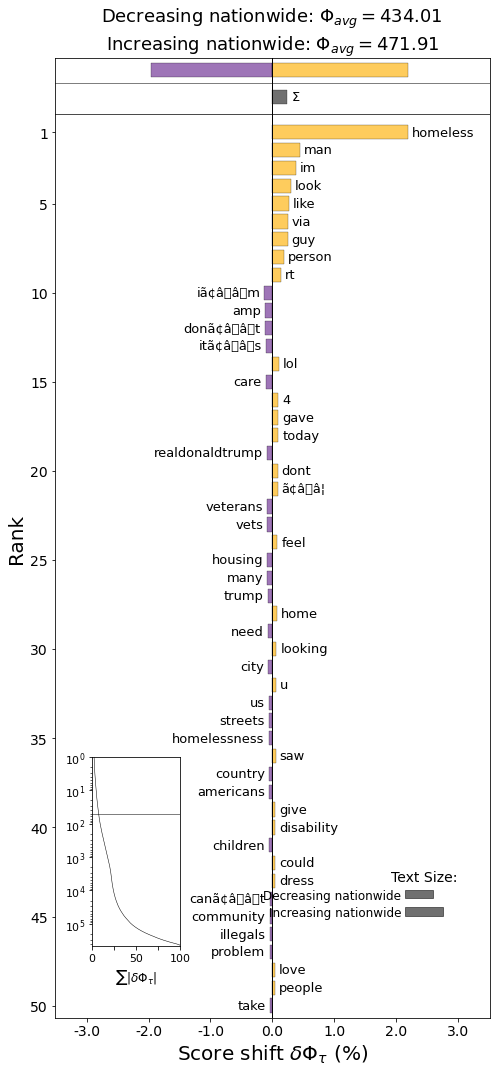

In [ ]:
word_shift(decreasingnationalcounter, increasingnationalcounter, alpha=0.5, desc1="Decreasing nationwide", desc2="Increasing nationwide")

# Prepares corpora for comparison of state-years with high homelessness versus state-years with low homelessness
Needs objects "high_homelessness_stateyears"

In [ ]:
highhomelessstateyearcorpus = []
lowhomelessstateyearcorpus = []

for index, stateyear in enumerate(df_w_stateyears['stateyear']):
  df_w_stateyears.at[index, 'stateyear'] = tuple(df_w_stateyears.loc[index]['stateyear'])
  if df_w_stateyears.loc[index]['stateyear'] in high_homelessness_stateyears:
    highhomelessstateyearcorpus.append(words_of_tweet(df.loc[index]['text']))
  if df_w_stateyears.loc[index]['stateyear'] in low_homelessness_stateyears:
    lowhomelessstateyearcorpus.append(words_of_tweet(df.loc[index]['text']))

# highhomelessstateyeartweets = list(df_w_stateyears.loc[df_w_stateyears['stateyear'] in high_homelessness_stateyears]['text'])
# for tweet in highhomelessstateyeartweets:
#   highhomelessstateyearcorpus.append(words_of_tweet(tweet))

# lowhomelessstateyeartweets = list(df_w_stateyears.loc[df_w_stateyears['stateyear'] in low_homelessness_stateyears]['tweet'])
# for tweet in lowhomelessstateyeartweets:
#   lowhomelessstateyearcorpus.append(words_of_tweet(tweet))


# Generates list of highest-frequency Twitter users in negatively-sentimented state-years versus positively-sentimented state-years

In [ ]:
# df_w_stateyears = pd.read_csv('drive/MyDrive/POCS FP/tweets/all_geotagged_tweets_w_stateyears.csv', engine = 'c', encoding = 'latin-1')

negyears = [('WY', '2010'), ('VT', '2010'), ('SC', '2010'), ('KS', '2010'), ('NH', '2010'),
            ('ID', '2010'), ('ME', '2010'), ('PA', '2010'), ('MD', '2010'), ('SD', '2010'),
            ('VT', '2011'), ('NH', '2011'), ('CO', '2010'), ('OK', '2010'), ('DE', '2010'), 
            ('HI', '2011'), ('WY', '2012'), ('AK', '2010'), ('RI', '2010'), ('MT', '2010')]

posyears = [('CT', '2018'), ('OR', '2014'), ('NV', '2019'), ('WY', '2018'), ('VT', '2019'),
            ('NV', '2018'), ('KS', '2019'), ('MN', '2018'), ('WY', '2017'), ('OK', '2018'),
            ('NE', '2018'), ('MA', '2019'), ('TN', '2019'), ('NV', '2015'), ('KY', '2018'),
            ('TN', '2018'), ('MA', '2018'), ('MI', '2018'), ('CT', '2019'), ('MO', '2018')]

neg_homelessness_stateyears = [str(monthyear) for monthyear in negyears]
pos_homelessness_stateyears = [str(monthyear) for monthyear in posyears]

# for x in states_without_dc_or_pr:
#   for y in negyears:
#     neg_homelessness_stateyears.append(str(tuple([x, y])))

# for x in states_without_dc_or_pr:
#   for y in postyears:
#     increasing_homelessness_stateyears.append(str(tuple([x, y])))

neghomelessness_users = []
poshomelessness_users = []
neghomelessness_usernames = []
poshomelessness_usernames = []

for row in df_w_stateyears.index:
  try:
    thisuser = json.loads(df_w_stateyears.loc[row]['author'])
    if df_w_stateyears.loc[row]['stateyear'] in neg_homelessness_stateyears:
      neghomelessness_users.append(thisuser['name'])
      neghomelessness_usernames.append(thisuser['username'])
    else:
      if df_w_stateyears.loc[row]['stateyear'] in pos_homelessness_stateyears:
        poshomelessness_users.append(thisuser['name'])
        poshomelessness_usernames.append(thisuser['username'])
  except:
    pass

neg_users = Counter(neghomelessness_users)
pos_users = Counter(poshomelessness_users)




In [ ]:
neg_users = Counter(neghomelessness_usernames)
pos_users = Counter(poshomelessness_usernames)

neg_users_decreasing = [x[0] for x in list(neg_users.most_common())[0:20]]
neg_freqs_decreasing = [x[1] for x in list(neg_users.most_common())[0:20]]

neg_states_users = pd.DataFrame(columns = ['User', 'Count'])
neg_states_users['User'] = neg_users_decreasing
neg_states_users['Count'] = neg_freqs_decreasing
neg_states_users['Type'] = ['News', 'News', 'Legislative', 'News', 'News', 
                            'News', 'News', 'News', 'News', 'News', 'News', 
                            'News', 'News', 'News', 'News', 'Individual', 'News', 'News', 
                            'News', 'News']

pos_users_increasing = [x[0] for x in list(pos_users.most_common())[0:20]]
pos_freqs_increasing = [x[1] for x in list(pos_users.most_common())[0:20]]

pos_states_users = pd.DataFrame(columns = ['User', 'Count'])
pos_states_users['User'] = pos_users_increasing
pos_states_users['Count'] = pos_freqs_increasing



pos_states_users['Type'] = ['Individual', 'Individual', 'Individual', 'Individual', 'Individual', 'News', 
                            'Agency', 'Individual', 'Individual', 'Agency', 'Individual', 'Individual', 'News', 
                            'Individual', 'Individual', 'Agency', 'Individual', 'Individual', 'Agency', 'Individual']
pos_states_users

# print(np.mean(pos_states_users.loc[pos_states_users['Type'] == 'Individual']['Count']))

# high_states_users
# news_tweets = (sum(high_states_users.loc[high_states_users['Type'] != 'Individual']['Count']))

# print(sum(increasing_states_users['Count'])/sum(increasing_users.values()))

# ind_tweets = (sum(neg_states_users.loc[neg_states_users['Type'] == 'Individual']['Count']))
# print(ind_tweets/sum(neg_states_users['Count']))
# print(sum(neg_states_users['Count'])/sum(neg_users.values()))

# lowest_users = list(low_users.most_common())[0:20]

# plt.bar(highest_users, high_freqs)
# plt.title('Users posting most frequently from \nhigh-homelessness states')
# plt.xticks(rotation = 90)
# plt.xlabel('User name')
# plt.ylabel('Number of posts \ncontaining "homeless"')
# plt.show()

# plt.bar(range(10), highest_users)
# plt.show()

# plt.bar(range(10), lowest_users)
# plt.show()
                             

,User,Count,Type
0,nadiasindi,1681,Individual
1,bloo40,521,Individual
2,New_Haven_Piano,410,Individual
3,KimWaterman,385,Individual
4,vegasscenemag,383,Individual
5,vbatcher50,242,News
6,codeofvets,198,Agency
7,AskMeBell,191,Individual
8,JimmyWayne,160,Individual
9,STBBoston,127,Agency


# Generates word cloud of highest-frequency Twitter users in high homelessness state-years

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


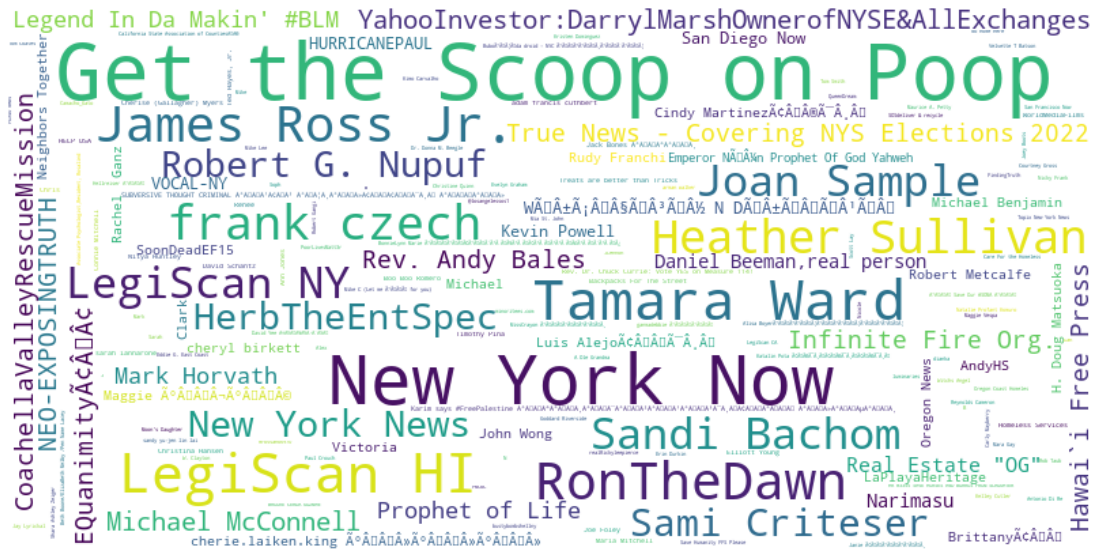

In [ ]:


wordcloud = WordCloud(background_color = 'white', width = 800, height = 400)
wordcloud.generate_from_frequencies(frequencies=Counter(highhomelessness_users))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


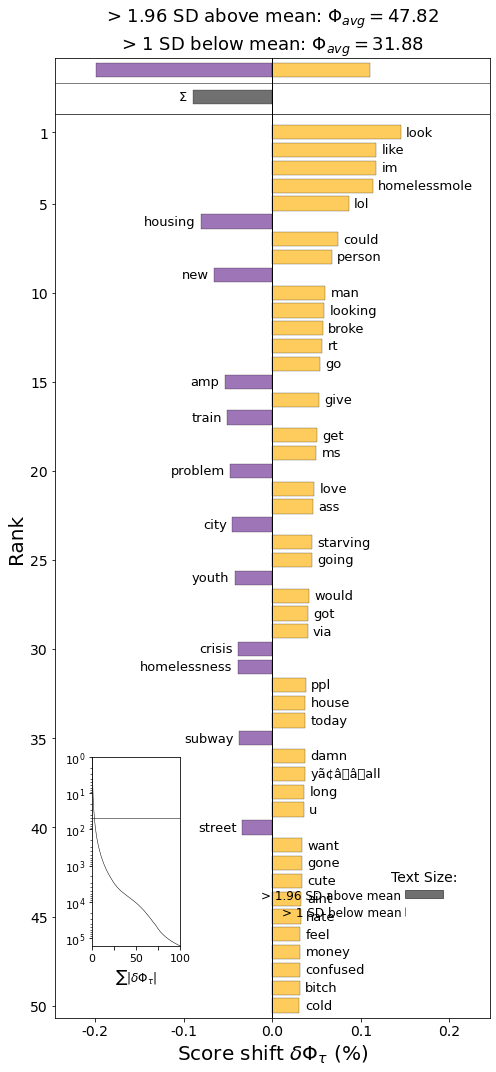

In [ ]:
# import itertools
# from itertools import chain

stops = set(stopwords.words('english'))
excludeme = ["san", "la", "nyc", "sf", "california", "seattle", "los", "oregons", "vegas", "angeles", "francisco", "ca", "redbluff", "las", 
             "indiana", "indy", "indianapolis", "chicago", "mississippi", "wichita", "jackson", "kansas", "homeless", "biloxi", "york"]


corpus1_forshift = []
corpus2_forshift = []

corpus1 = [item for sublist in lowhomelessstateyearcorpus for item in sublist]
corpus2 = [item for sublist in highhomelessstateyearcorpus for item in sublist]

for word in corpus1:
  if word not in stops and word not in excludeme:
    corpus1_forshift.append(word)

for word in corpus2:
  if word not in stops and word not in excludeme:
    corpus2_forshift.append(word)

highhomelesscorpuscount = Counter(corpus2_forshift)
lowhomelesscorpuscount = Counter(corpus1_forshift)

word_shift(highhomelesscorpuscount, lowhomelesscorpuscount, alpha = 0.75, desc1 = '> 1.96 SD above mean', desc2 = "> 1 SD below mean")

# Plots side-by-side boxplots of distribution of cross-correlation coefficients between total homelessness rates and per capita tweet rates over 2010-2019

In [ ]:
percapita_changes_totalhomeless.set_index('Unnamed: 0', drop = True, inplace = True)

In [ ]:
corr_df2 = cross_correlate(normalized_totalhomeless, percapita_tweets)
corr_df3 = cross_correlate(normalized_unshelteredhomeless, percapita_tweets)

In [ ]:
corr_dict = {}

for timestep, statelist in corr_df2.items():
  corr_dict[timestep] = []
  for dat in statelist:
    if dat[1]>0.7 or dat[1]<-0.7:
      corr_dict[timestep].append(dat)

for key in corr_dict.keys():
  print(key, sorted(corr_dict[key], key = lambda x: x[1]))

1 [('TX', -0.9151043087549321), ('FL', -0.9143573133513652), ('LA', -0.899030347819548), ('VA', -0.8959721480797882), ('OK', -0.8916555365740972), ('KY', -0.8564477410307774), ('CO', -0.8439926070746948), ('OR', -0.8439144445899246), ('MT', -0.8266503011154037), ('NV', -0.7933616870950564), ('MD', -0.7918307286020716), ('NH', -0.7760431262031532), ('AZ', -0.7660442699917791), ('GA', -0.7493627823964247), ('NE', -0.7381201277304736), ('AL', -0.7332307959190524), ('NC', -0.7311038474269425), ('ND', 0.7611896757631489), ('MA', 0.871715875170709), ('NY', 0.8892215341444093)]
2 [('MO', -0.8407658532952371), ('NC', -0.8211657957112831), ('TX', -0.8078989445375961), ('FL', -0.79691357491414), ('VA', -0.777677201081966), ('OH', -0.7534146305211503), ('GA', -0.7486163134759913), ('MT', -0.7236080237522081), ('UT', -0.7199013775411568), ('NY', 0.8199547009416763)]
3 [('UT', -0.8524654138353517), ('MO', -0.8184057075866853), ('WV', -0.7936848382572146), ('OH', -0.7698075947564339)]
4 [('SC', -0.9

[1, 2, 3, 4, 5, 6, 7, 8]


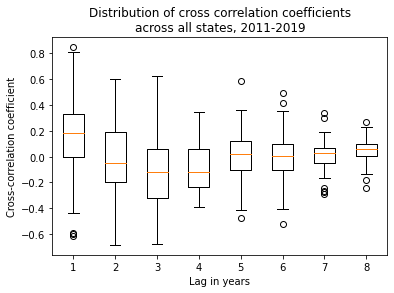

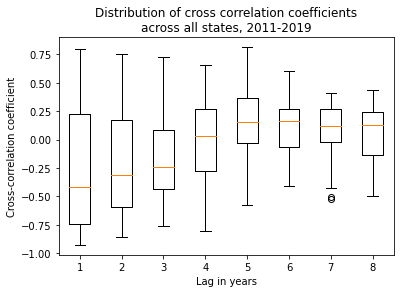

In [ ]:
years = sorted(list(corr_df2.keys()))
print(years)

xcoords = years
ycoords = [corr_df2[year] for year in xcoords]

plt.boxplot(ycoords)
plt.title('Distribution of cross correlation coefficients\nacross all states, 2011-2019')
plt.xlabel('Lag in years')
plt.ylabel('Cross-correlation coefficient')
plt.show()

ycoords = [corr_df3[year] for year in xcoords]

plt.boxplot(ycoords)
plt.title('Distribution of cross correlation coefficients\nacross all states, 2011-2019')
plt.xlabel('Lag in years')
plt.ylabel('Cross-correlation coefficient')
plt.show()


# Plots correlation coefficient over time to see if increase in Twitter data volume generally might be picking up better on signal

In [ ]:
plt.plot(range(2010, 2018), lr_coords)
plt.title('Slope of relationship between log-normalized total homelessness \nand log-normalized tweet volume over time')
plt.xlabel('Year')
plt.ylabel('Slope in year X')
plt.show()


# Plots each year's changes in homelessness rates against changes in tweet rates with linear regression
NEEDS FIXING: Years are cumulative and not separate 

<Figure size 432x288 with 0 Axes>

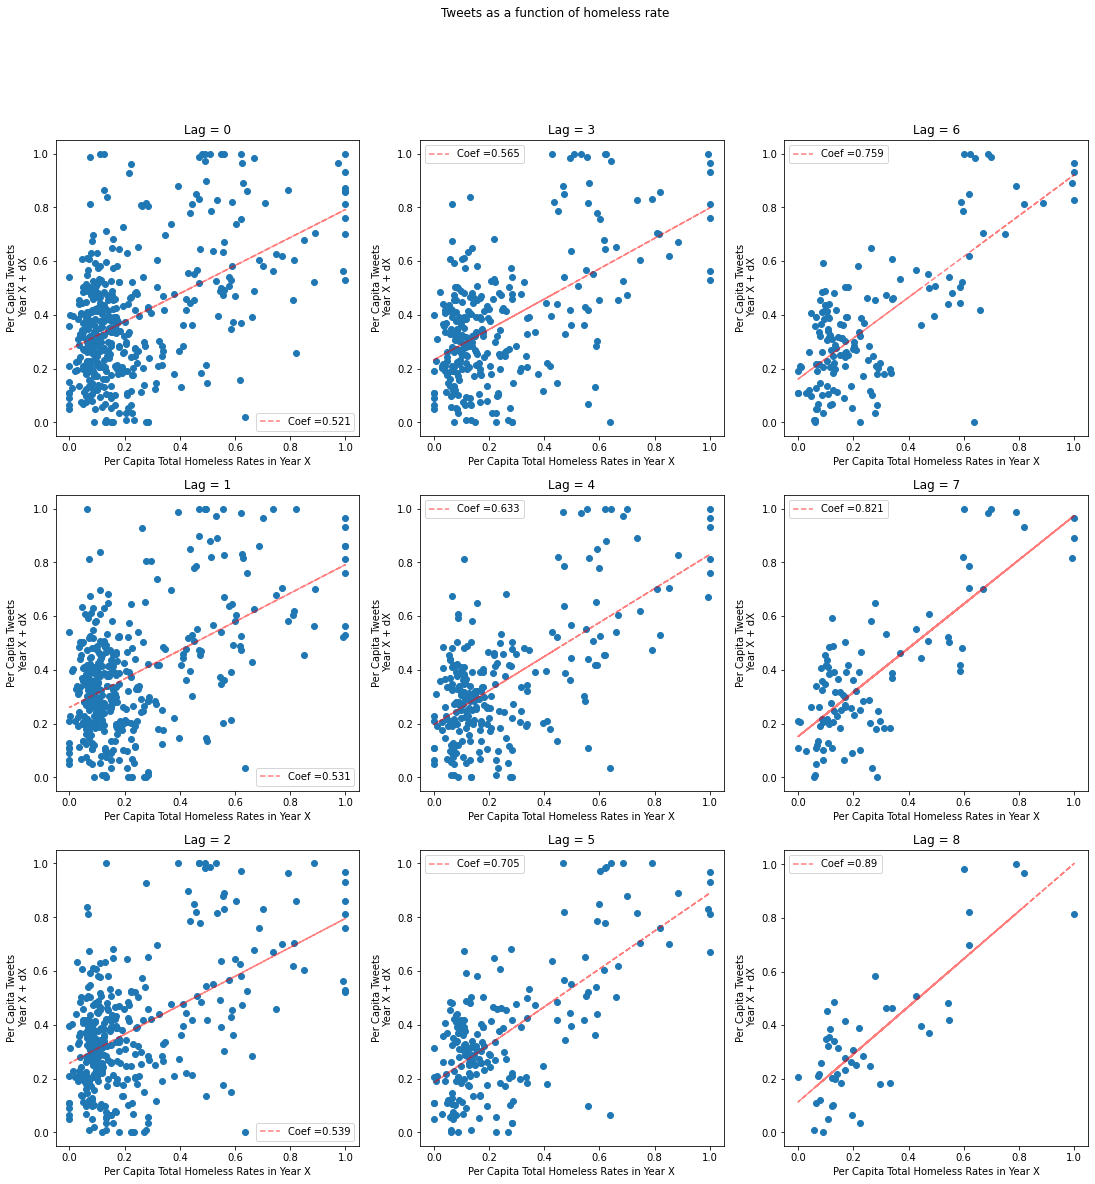

In [ ]:
plt.gcf()

fig, axes = plt.subplots(3,3)
axcol = 0
axrow = 0
fig.set_size_inches(18.5, 18.5)


# for lag in range(9):
#   years = [str(x) for x in range(2010, 2019-lag)]
#   xcoords = []
#   ycoords = []
#   for year in years:
#     for state in states_without_dc_or_pr:
#       xcoords.append(normalized_percapita_totalhomeless_changes.loc[state][year])
#       ycoords.append(normalized_percapita_tweets.loc[state][str(int(year) + lag)])
#   lr = sk.linear_model.LinearRegression().fit(np.array(xcoords).reshape(-1, 1), ycoords)
#   lr_ycoords = [lr.coef_ * x + lr.intercept_ for x in xcoords]
#   axes[axrow, axcol].scatter(xcoords, ycoords)
#   axes[axrow, axcol].plot(xcoords, lr_ycoords, '--', color = 'red', alpha = 0.5)
#   axes[axrow, axcol].set_xlabel('Per Capita Increase to Total Homeless Rates in Year X')
#   axes[axrow, axcol].set_ylabel('Percent of Tweets\n Year X + dX')
#   axes[axrow, axcol].legend(['Coef =' + str(round(float(lr.coef_), 3))])
#   axes[axrow, axcol].set_title('Lag = ' + str(lag))
#   plt.suptitle('Tweets as a function of homeless rate')
#   if axrow == 2:
#     axcol +=1
#     axrow = 0
#   else:
#     axrow +=1

# plt.show()


for delay in range(9):
  years = [str(x) for x in range(2010+delay, 2019)]
  xcoords = []
  ycoords = []
  for year in years:
    for state in states_without_dc_or_pr:
      xcoords.append(normalized_percapita_totalhomeless_changes.loc[state][year])
      ycoords.append(normalized_percapita_tweets.loc[state][str(int(year) + delay)])
  lr = sk.linear_model.LinearRegression().fit(np.array(xcoords).reshape(-1, 1), ycoords)
  lr_ycoords = [lr.coef_ * x + lr.intercept_ for x in xcoords]
  axes[axrow, axcol].scatter(xcoords, ycoords)
  axes[axrow, axcol].plot(xcoords, lr_ycoords, '--', color = 'red', alpha = 0.5)
  axes[axrow, axcol].set_xlabel('Per Capita Increase to Total Homeless Rates in Year X')
  axes[axrow, axcol].set_ylabel('Percent of Tweets\nß Year X + dX')
  axes[axrow, axcol].legend(['Coef =' + str(round(float(lr.coef_), 3))])
  axes[axrow, axcol].set_title('Lag = ' + str(lag))
  plt.suptitle('Tweets as a function of homeless rate')
  if axrow == 2:
    axcol +=1
    axrow = 0
  else:
    axrow +=1

plt.show()

# **SECTION SIX: MACHINE LEARNING** 

# Prediction using Polynomial Features Linear Regression Object

In [ ]:
PLR_dataset = pd.DataFrame(columns = ['Year', 'State', 'Raw_Homeless', 'Per_Capita_Homeless', 'Percent_Nation_Homeless', 'Per_Capita_Change_Homeless', 'Per_SqMi_Homeless', 'Per_SqMi_Change_Homeless', 'Per_Capita_Tweet', 'Per_Capita_Change_Tweet', 'Percent_Nation_Tweet'])

In [ ]:
for col in percapita_changes_totalhomeless.columns:
  for state in states_without_dc_or_pr:
    PLR_dataset.loc[len(PLR_dataset)] = [col, state, raw_totalhomeless.loc[state, col], normalized_totalhomeless.loc[state, col], 999, percapita_changes_totalhomeless.loc[state, col], persqmi_totalhomeless.loc[state, col], 999, percapita_tweets.loc[state, col], percapita_changes_tweets.loc[state, col], percents_of_tweets.loc[state,col]]

In [ ]:
PLR_dataset

,Year,State,Raw_Homeless,Per_Capita_Homeless,Percent_Nation_Homeless,Per_Capita_Change_Homeless,Per_SqMi_Homeless,Per_SqMi_Change_Homeless,Per_Capita_Tweet,Per_Capita_Change_Tweet,Percent_Nation_Tweet
0,2011,AK,2128.0,0.002947,999,0.000337,0.003729,999,0.000109,0.000070,0.002822
1,2011,AL,5558.0,0.001158,999,-0.000105,0.109744,999,0.000068,0.000053,0.011645
2,2011,AR,3424.0,0.001164,999,0.000219,0.065802,999,0.000107,0.000093,0.011216
3,2011,AZ,10504.0,0.001623,999,-0.000517,0.092470,999,0.000045,0.000028,0.010323
4,2011,CA,125128.0,0.003324,999,0.000016,0.803240,999,0.000123,0.000086,0.164702
...,...,...,...,...,...,...,...,...,...,...,...
445,2019,VT,1089.0,0.001745,999,-0.000323,0.118151,999,0.000141,-0.000035,0.000904
446,2019,WA,21577.0,0.002834,999,-0.000131,0.324681,999,0.000425,-0.000054,0.033263
447,2019,WI,4538.0,0.000779,999,-0.000066,0.083792,999,0.000114,-0.000002,0.006788
448,2019,WV,1397.0,0.000780,999,0.000091,0.058116,999,0.000158,-0.000028,0.002917


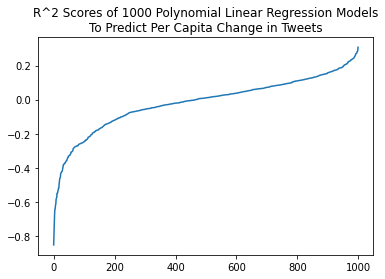

[ 2.51391890e-10  5.69380059e-02  1.12909214e-02  3.70964667e-05
  6.24500451e-17  2.95715659e-08 -2.53845078e-06 -3.16535570e-10
 -1.04920027e+01 -9.94928002e-02  4.94289614e-03 -5.03310341e-01
  1.28188889e-01 -2.38299938e-05]
0.3072517914115024


In [ ]:
ycoords = []
xcoords = []
PLRs = []

X = PLR_dataset[['Raw_Homeless', 'Per_Capita_Homeless', 'Per_Capita_Change_Homeless', 'Per_SqMi_Homeless']]
Y = PLR_dataset['Per_Capita_Change_Tweet']
PLR_X = sk.preprocessing.PolynomialFeatures(degree = 2, include_bias = False).fit_transform(X)

for x in range(1000):
  Xtrain, Xtest, ytrain, ytest = sk.model_selection.train_test_split(PLR_X, Y, test_size=0.1)
  PLR = sk.linear_model.LinearRegression().fit(Xtrain, ytrain)
  ycoords.append(PLR.score(Xtest, ytest))
  xcoords.append(x)
  PLRs.append(PLR)

PLRidx = ycoords.index(max(ycoords))
bestPLR = PLRs[PLRidx]
ycoords = sorted(ycoords)
plt.plot(xcoords, ycoords)
plt.title('R^2 Scores of 1000 Polynomial Linear Regression Models\nTo Predict Per Capita Change in Tweets')
plt.show()

print(bestPLR.coef_)
print(max(ycoords))

In [ ]:
# for year in normalized_totalhomeless.columns:
#   pd.to_numeric(normalized_totalhomeless[year])

# normalized_totalhomeless.loc[len(normalized_totalhomeless)] = [np.average(normalized_totalhomeless[year]) for year in normalized_totalhomeless.columns]
# normalized_totalhomeless.loc[len(normalized_totalhomeless)] = [np.std(normalized_totalhomeless[year]) for year in normalized_totalhomeless.columns]

# normalized_totalhomeless_std = pd.DataFrame(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], index = states_without_dc_or_pr)

# for state in normalized_totalhomeless.index[0:-2]:
#   for year in normalized_totalhomeless.columns:
#     normalized_totalhomeless_std.at[state, year] = (normalized_totalhomeless.loc[state][year]-normalized_totalhomeless.loc[50][year])/normalized_totalhomeless.loc[51][year]
